# Gene Sequence Matching for Annotation between K12 b# and NCBI

# 1. Load
### 1.1 packages

In [1]:
# Sample alignment with pairwise2
# http://biopython.org/DIST/docs/api/Bio.pairwise2-module.html
from Bio import pairwise2
alignments = pairwise2.align.globalxx("MRVLKFGGTSVANAERFLRVAD", "GTSVANAER")

from Bio.pairwise2 import format_alignment
print(format_alignment(*alignments[0]))

MRVLKFGGTSVANAERFLRVAD
       ||||||||   |   
-------GTSVANAE---R---
  Score=9



In [2]:
import pandas as pd
from Bio import pairwise2
import rglonDB_parse as rp
import ecocyc_parse as ep
from Bio import SeqIO
import numpy as np
import time

pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

### 1.2 Load Ecocyc files

In [3]:
gene_col_file = "HelpFiles/Ecyc-K12/genes.col"
gene_seq_file = "HelpFiles/Ecyc-K12/dnaseq.fsa.prepared"
gene_pro_file = "HelpFiles/Ecyc-K12/protseq.fsa"
prot_lnk_file = "HelpFiles/Ecyc-K12/protein-links.dat"

### 1.2.1 Gene columns info

In [4]:
gene_col = ep.parse_col(gene_col_file)
gene_col.head(3)

,UNIQUE-ID,BLATTNER-ID,NAME,PRODUCT-NAME,SWISS-PROT-ID,REPLICON,START-BASE,END-BASE,SYNONYMS,SYNONYMS.1,SYNONYMS.2,SYNONYMS.3,GENE-CLASS,GENE-CLASS.1,GENE-CLASS.2,GENE-CLASS.3
0,G6986,b1800,dmlA,D-malate/3-isopropylmalate dehydrogenase (deca...,P76251,COLI-K12,1881912.0,1882997.0,ttuC,yeaU,NaN,NaN,carbon compounds,NaN,NaN,NaN
1,G0-10525,NaN,insEF-1,IS3 element transposase,NaN,COLI-K12,315291.0,316453.0,NaN,NaN,NaN,NaN,transposon related,NaN,NaN,NaN
2,G6627,b1200,dhaK,dihydroxyacetone kinase subunit K,P76015,COLI-K12,1250838.0,1249768.0,ycgT,dhaK1,NaN,NaN,carbon compounds,NaN,NaN,NaN


Notice that not all genes have a blatter id. 

In [5]:
gene_col.shape

(4534, 16)

### 1.2.2 Gene sequence info

In [6]:
gen_ids = []
seq_list = []
for record in SeqIO.parse(gene_seq_file, "fasta"):

    seq = str(record.seq).upper()
    des = (record.id).replace("gnl|ECOLI|", "")
    gen_ids.append(des)
    seq_list.append(seq)
    #print(des, seq, "\n")

In [7]:
gen_seq = pd.DataFrame({"gene_id": gen_ids, "gene_sequence": seq_list})
gen_seq.head(3)

,gene_id,gene_sequence
0,EG11277,ATGAAACGCATTAGCACCACCATTACCACCACCATCACCATTACCA...
1,EG10998,ATGCGAGTGTTGAAGTTCGGCGGTACATCAGTGGCAAATGCAGAAC...
2,EG10999,ATGGTTAAAGTTTATGCCCCGGCTTCCAGTGCCAATATGAGCGTCG...


In [8]:
gen_seq.shape

(4622, 2)

### 1.2.3 Protein sequence info

In [9]:
pro_ids = []
pro_seq_list = []
for record in SeqIO.parse(gene_pro_file, "fasta"):
    #print(record)
    seq = str(record.seq)
    des = (record.id).replace("gnl|ECOLI|", "")
    pro_ids.append(des)
    pro_seq_list.append(seq)
    #print(des, seq, "\n")

In [10]:
gen_pro = pd.DataFrame({"pro_id": pro_ids, "pro_sequence": pro_seq_list})
gen_pro.head(3)

,pro_id,pro_sequence
0,EG10711-MONOMER,MSLPHCPKCNSEYTYEDNGMYICPECAYEWNDAEPAQESDELIVKD...
1,G6571-MONOMER,MMIKTRFSRWLTFFTFAAAVALALPAKANTWPLPPAGSRLVGENKF...
2,G6500-MONOMER,MIASKFGIGQQVRHSLLGYLGVVVDIDPVYSLSEPSPDELAVNDEL...


In [11]:
gen_pro.shape

(4303, 2)

### 1.2.4 Protein Gene Link

In [12]:
pro_lnk = ep.parse_mul_linkdat(prot_lnk_file)
pro_lnk.head(3)

,0,1,2,3,4
0,G7664-MONOMER,G7664,P0ADV9,lipopolysaccharide transport system protein LptC,YrbK
1,KUP-MONOMER,EG11541,P63183,K<sup>+</sup>:H<sup>+</sup> symporter Kup,"TrkD, Kup"
2,G6437-MONOMER,G6437,P75804,aldose sugar dehydrogenase YliI,YliI


In [13]:
# adding header
pro_lnk_col = ["pro_id", "gene_id", "up_id", "note", "name"]
pro_lnk.columns = pro_lnk_col
pro_lnk.head()

,pro_id,gene_id,up_id,note,name
0,G7664-MONOMER,G7664,P0ADV9,lipopolysaccharide transport system protein LptC,YrbK
1,KUP-MONOMER,EG11541,P63183,K<sup>+</sup>:H<sup>+</sup> symporter Kup,"TrkD, Kup"
2,G6437-MONOMER,G6437,P75804,aldose sugar dehydrogenase YliI,YliI
3,ARGS-MONOMER,EG10071,P11875,arginine&mdash;tRNA ligase,"Lov, ArgS, ArgRS"
4,MONOMER0-4483,G0-17017,P0DSE9,protein YchT,YchT


### 1.2.5 Merge Protein info
由于我必须要使用蛋白质序列来进行后续的比对，所以要以蛋白质序列的数据框为准。

In [14]:
pro_info = pd.merge(
    gen_pro, pro_lnk,
    how = "left",
    on = "pro_id"
)
pro_info.head(3)

,pro_id,pro_sequence,gene_id,up_id,note,name
0,EG10711-MONOMER,MSLPHCPKCNSEYTYEDNGMYICPECAYEWNDAEPAQESDELIVKD...,EG10711,P0AFJ1,zinc ribbon domain-containing protein YjdM,"YjdM, PhnA"
1,G6571-MONOMER,MMIKTRFSRWLTFFTFAAAVALALPAKANTWPLPPAGSRLVGENKF...,G6571,P75954,"L,D-transpeptidase LdtC","LdtC, YcfS"
2,G6500-MONOMER,MIASKFGIGQQVRHSLLGYLGVVVDIDPVYSLSEPSPDELAVNDEL...,G6500,P0AB20,"heat shock protein, hemimethylated DNA-binding...","YccV, HspQ"


In [15]:
pro_info.shape

(4303, 6)

In [16]:
# Since we need protein sequences for match, and need gene id for linking
# remove na in these two columns
pro_info.dropna(subset=['pro_sequence', 'gene_id'], inplace = True)
pro_info.shape

(4303, 6)

Great! It seems that there are no missing info here. 
### 1.2.6 Merge gene info

In [17]:
gen_info = pd.merge(
    gene_col, gen_seq,
    how = "left",
    left_on = "UNIQUE-ID",
    right_on = "gene_id"
)
gen_info.head(3)

,UNIQUE-ID,BLATTNER-ID,NAME,PRODUCT-NAME,SWISS-PROT-ID,REPLICON,START-BASE,END-BASE,SYNONYMS,SYNONYMS.1,SYNONYMS.2,SYNONYMS.3,GENE-CLASS,GENE-CLASS.1,GENE-CLASS.2,GENE-CLASS.3,gene_id,gene_sequence
0,G6986,b1800,dmlA,D-malate/3-isopropylmalate dehydrogenase (deca...,P76251,COLI-K12,1881912.0,1882997.0,ttuC,yeaU,NaN,NaN,carbon compounds,NaN,NaN,NaN,G6986,ATGATGAAAACGATGCGTATTGCTGCGATCCCGGGAGACGGGATTG...
1,G0-10525,NaN,insEF-1,IS3 element transposase,NaN,COLI-K12,315291.0,316453.0,NaN,NaN,NaN,NaN,transposon related,NaN,NaN,NaN,G0-10525,GTGACTCACATGACAAAAACAGTATCAACCAGTAAAAAACCCCGTA...
2,G6627,b1200,dhaK,dihydroxyacetone kinase subunit K,P76015,COLI-K12,1250838.0,1249768.0,ycgT,dhaK1,NaN,NaN,carbon compounds,NaN,NaN,NaN,G6627,ATGAAAAAATTGATCAATGATGTGCAAGACGTACTGGACGAACAAC...


In [18]:
gen_info.shape

(4534, 18)

### 1.2.7 Final Merge for ecyc_info

In [19]:
gen_info.shape, pro_info.shape

((4534, 18), (4303, 6))

In [20]:
ecyc_info = pd.merge(
    gen_info, pro_info,
    how = "left",
    left_on = "UNIQUE-ID",
    right_on = "gene_id"
)
ecyc_info.head(3)

,UNIQUE-ID,BLATTNER-ID,NAME,PRODUCT-NAME,SWISS-PROT-ID,REPLICON,START-BASE,END-BASE,SYNONYMS,SYNONYMS.1,SYNONYMS.2,SYNONYMS.3,GENE-CLASS,GENE-CLASS.1,GENE-CLASS.2,GENE-CLASS.3,gene_id_x,gene_sequence,pro_id,pro_sequence,gene_id_y,up_id,note,name
0,G6986,b1800,dmlA,D-malate/3-isopropylmalate dehydrogenase (deca...,P76251,COLI-K12,1881912.0,1882997.0,ttuC,yeaU,NaN,NaN,carbon compounds,NaN,NaN,NaN,G6986,ATGATGAAAACGATGCGTATTGCTGCGATCCCGGGAGACGGGATTG...,G6986-MONOMER,MMKTMRIAAIPGDGIGKEVLPEGIRVLQAAAERWGFALSFEQMEWA...,G6986,P76251,D-malate/3-isopropylmalate dehydrogenase (deca...,"YeaU, TtuC, DmlA"
1,G0-10525,NaN,insEF-1,IS3 element transposase,NaN,COLI-K12,315291.0,316453.0,NaN,NaN,NaN,NaN,transposon related,NaN,NaN,NaN,G0-10525,GTGACTCACATGACAAAAACAGTATCAACCAGTAAAAAACCCCGTA...,MONOMER0-2748,MTKTVSTSKKPRKQHSPEFRSEALKLAERIGVTAAARELSLYESQL...,G0-10525,NaN,IS3 element transposase,NaN
2,G6627,b1200,dhaK,dihydroxyacetone kinase subunit K,P76015,COLI-K12,1250838.0,1249768.0,ycgT,dhaK1,NaN,NaN,carbon compounds,NaN,NaN,NaN,G6627,ATGAAAAAATTGATCAATGATGTGCAAGACGTACTGGACGAACAAC...,G6627-MONOMER,MKKLINDVQDVLDEQLAGLAKAHPSLTLHQDPVYVTRADAPVAGKV...,G6627,P76015,dihydroxyacetone kinase subunit K,"YcgT, DhaK"


In [21]:
ecyc_info.shape

(4540, 24)

### 1.3 Load NCBI file
### 1.3.1 Load NCBI sequence file

In [22]:
ncbi_info_file = "HelpFiles/NCBI_EcoliBREL606_annseq.csv"
ncbi_info = pd.read_csv(ncbi_info_file, header=0, index_col=0)
ncbi_info.head(3)

,locus_tag,name,location,old_locus_tag,product,note,start,end,sequence
0,ECB_RS00005,thrL,[189:255](+),ECB_00001,thr operon leader peptide,Derived by automated computational analysis us...,189,255,ATGAAACGCATTAGCACCACCATTACCACCACCATCACCATTACCA...
1,ECB_RS00010,thrA,[335:2798](+),ECB_00002,bifunctional aspartate kinase/homoserine dehyd...,Derived by automated computational analysis us...,335,2798,ATGCGAGTGTTGAAGTTCGGCGGTACATCAGTGGCAAATGCAGAAC...
2,ECB_RS00015,thrB,[2799:3732](+),ECB_00003,homoserine kinase,Derived by automated computational analysis us...,2799,3732,ATGGTTAAAGTTTATGCCCCGGCTTCCAGTGCCAATATGAGCGTCG...


In [23]:
ncbi_info.shape

(4488, 9)

### 1.3.2 Load NCBI protein sequence file

In [24]:
ncbi_pro_file = "HelpFiles/NCBI_rel606/REL606-NC_012967.1.gb"

In [25]:
gen_ids = []
seq_list = []
gb_record = SeqIO.read(ncbi_pro_file, "genbank")
for feature in gb_record.features:
    
    if feature.type =="CDS":
        ecb = None
        seq = None
        keys = feature.qualifiers.keys()
        if "locus_tag" in keys:
            ecb = feature.qualifiers["locus_tag"][0]
        if "translation" in keys:
            seq = feature.qualifiers["translation"][0]
        # print(ecb, seq)
        gen_ids.append(ecb)
        seq_list.append(seq)

In [26]:
ncbi_pro = pd.DataFrame({"gene_id": gen_ids, "protein_sequence": seq_list})
ncbi_pro.head(3)

,gene_id,protein_sequence
0,ECB_RS00005,MKRISTTITTTITITTGNGAG
1,ECB_RS00010,MRVLKFGGTSVANAERFLRVADILESNARQGQVATVLSAPAKITNH...
2,ECB_RS00015,MVKVYAPASSANMSVGFDVLGAAVTPVDGALLGDVVTVEAAETFSL...


In [27]:
ncbi_pro.shape

(4372, 2)

### 1.3.3 Merge NCBI files

In [28]:
ncbi_merge = pd.merge(
    ncbi_info, ncbi_pro,
    how = "left",
    left_on = "locus_tag",
    right_on = "gene_id"
)
ncbi_merge.head(3)

,locus_tag,name,location,old_locus_tag,product,note,start,end,sequence,gene_id,protein_sequence
0,ECB_RS00005,thrL,[189:255](+),ECB_00001,thr operon leader peptide,Derived by automated computational analysis us...,189,255,ATGAAACGCATTAGCACCACCATTACCACCACCATCACCATTACCA...,ECB_RS00005,MKRISTTITTTITITTGNGAG
1,ECB_RS00010,thrA,[335:2798](+),ECB_00002,bifunctional aspartate kinase/homoserine dehyd...,Derived by automated computational analysis us...,335,2798,ATGCGAGTGTTGAAGTTCGGCGGTACATCAGTGGCAAATGCAGAAC...,ECB_RS00010,MRVLKFGGTSVANAERFLRVADILESNARQGQVATVLSAPAKITNH...
2,ECB_RS00015,thrB,[2799:3732](+),ECB_00003,homoserine kinase,Derived by automated computational analysis us...,2799,3732,ATGGTTAAAGTTTATGCCCCGGCTTCCAGTGCCAATATGAGCGTCG...,ECB_RS00015,MVKVYAPASSANMSVGFDVLGAAVTPVDGALLGDVVTVEAAETFSL...


In [29]:
ncbi_merge.drop(["gene_id"], axis=1, inplace = True)

In [30]:
ncbi_merge.head(3)

,locus_tag,name,location,old_locus_tag,product,note,start,end,sequence,protein_sequence
0,ECB_RS00005,thrL,[189:255](+),ECB_00001,thr operon leader peptide,Derived by automated computational analysis us...,189,255,ATGAAACGCATTAGCACCACCATTACCACCACCATCACCATTACCA...,MKRISTTITTTITITTGNGAG
1,ECB_RS00010,thrA,[335:2798](+),ECB_00002,bifunctional aspartate kinase/homoserine dehyd...,Derived by automated computational analysis us...,335,2798,ATGCGAGTGTTGAAGTTCGGCGGTACATCAGTGGCAAATGCAGAAC...,MRVLKFGGTSVANAERFLRVADILESNARQGQVATVLSAPAKITNH...
2,ECB_RS00015,thrB,[2799:3732](+),ECB_00003,homoserine kinase,Derived by automated computational analysis us...,2799,3732,ATGGTTAAAGTTTATGCCCCGGCTTCCAGTGCCAATATGAGCGTCG...,MVKVYAPASSANMSVGFDVLGAAVTPVDGALLGDVVTVEAAETFSL...


In [31]:
ncbi_merge.protein_sequence.isna().sum()

298

In [32]:
ncbi_merge.to_csv("HelpFiles/NCBI_rel606_gene_protein_seq.csv")

# 2. Matching

### 2.1 Matching sequence alignment

In [83]:
def align_match(left_df, right_df, id_left, id_right, seq_left, seq_right):
    """
    Describe: The function take in two dataframe and related info, matching the id with sequence alignments
    Input:
        left_df - (pd.DataFrame) left dataframe -> THE AIM DATAFRAME
        right_df - (pd.DataFrame) right dataframe
        id_left - (string) identifier for left_df
        id_right - (string) identifier for right_df
        seq_left - (string) column label for sequence for left_df
        seq_right - (string) column label for sequence for right_df       
    output:
        right_gene_ids - (list)
        right_gene_len - (list)
        left_gene_len - (list)
        left_gene_ids - (list)
        align_scores - (list)
        aligh_len - (list)
        align_similar - (list)
    """
    left_df.index = np.arange(len(left_df))    # change the index for looping
    right_df.index = np.arange(len(right_df))
    
    left_id_list = left_df[id_left].tolist()    # list of ids for the dataframe
    right_id_list = right_df[id_right].tolist()

    right_gene_ids = []
    right_gene_len = []
    left_gene_len = []
    left_gene_ids = []
    align_scores = []
    aligh_len = []
    align_similar = []
    i = 0
    while i < len(left_id_list):
        l_id = left_id_list[i]
        left_seq = left_df.loc[i, seq_left]

        score_list = []
        len_list = []
        align_list = []
        start = time.time()
        
        j = 0
        while j<len(right_id_list):
            r_id = right_id_list

            right_seq = right_df.loc[j, seq_right]
            
            #print(left_seq, right_seq)
            
            align = None
            score = 0.0
            length = 333.0

            if pd.isnull(right_seq)==True or pd.isnull(left_seq)==True:
                pass
            else:
                left_len = float(len(left_seq))
                right_len = float(len(right_seq))

                if right_len>1.25*left_len or right_len<0.25*left_len:
                    pass
                else:

                    align = pairwise2.align.globalxx(left_seq, right_seq,  
                                                  penalize_extend_when_opening = True,
                                                  one_alignment_only = True)
                    score = float(align[0][2])
                    length = float(align[0][4])

            score_list.append(score)
            len_list.append(length)
            align_list.append(align)
            
            j = j+1

        if len(score_list)!=len(right_id_list):
            print("Index not look right!")
            break
        elif pd.isnull(left_seq)==True:
            i = i+1
            continue
        else:
            similarity_list = np.asarray(score_list)/np.asanyarray(len_list)
            ind = np.argmax(similarity_list)    # select the index for the max similarities

            final_score = score_list[ind]
            final_len = len_list[ind]
            final_similarity = similarity_list[ind]
            final_right_id = right_id_list[ind]
            left_len = float(len(left_seq))
            right_len = float(len(right_df.loc[ind, seq_right]))
            best_align = align_list[ind]
            
            right_gene_ids.append(final_right_id)
            right_gene_len.append(right_len)
            left_gene_len.append(left_len)
            left_gene_ids.append(l_id)
            align_scores.append(final_score)
            aligh_len.append(final_len)
            align_similar.append(final_similarity)

            end = time.time()

            print(l_id, final_right_id, final_similarity, left_len, end - start, i) 
            i = i+1
        
    return (left_gene_ids, left_gene_len, 
            right_gene_ids, right_gene_len,  
            align_scores, aligh_len, align_similar)

In [34]:
ncbi_merge.head(1)

,locus_tag,name,location,old_locus_tag,product,note,start,end,sequence,protein_sequence
0,ECB_RS00005,thrL,[189:255](+),ECB_00001,thr operon leader peptide,Derived by automated computational analysis us...,189,255,ATGAAACGCATTAGCACCACCATTACCACCACCATCACCATTACCA...,MKRISTTITTTITITTGNGAG


In [35]:
ncbi_merge.shape

(4488, 10)

In [36]:
# there is no redundancy in the ncbi genes
ncbi_merge.drop_duplicates(subset=["locus_tag"]).shape

(4488, 10)

In [37]:
ecyc_info.head(1)

,UNIQUE-ID,BLATTNER-ID,NAME,PRODUCT-NAME,SWISS-PROT-ID,REPLICON,START-BASE,END-BASE,SYNONYMS,SYNONYMS.1,SYNONYMS.2,SYNONYMS.3,GENE-CLASS,GENE-CLASS.1,GENE-CLASS.2,GENE-CLASS.3,gene_id_x,gene_sequence,pro_id,pro_sequence,gene_id_y,up_id,note,name
0,G6986,b1800,dmlA,D-malate/3-isopropylmalate dehydrogenase (deca...,P76251,COLI-K12,1881912.0,1882997.0,ttuC,yeaU,NaN,NaN,carbon compounds,NaN,NaN,NaN,G6986,ATGATGAAAACGATGCGTATTGCTGCGATCCCGGGAGACGGGATTG...,G6986-MONOMER,MMKTMRIAAIPGDGIGKEVLPEGIRVLQAAAERWGFALSFEQMEWA...,G6986,P76251,D-malate/3-isopropylmalate dehydrogenase (deca...,"YeaU, TtuC, DmlA"


In [38]:
ecyc_info.shape

(4540, 24)

In [39]:
# There are a few redundacy for the id, since some of the genes have more than one matching.
ecyc_info.drop_duplicates(subset=["UNIQUE-ID"]).shape

(4534, 24)

In [40]:
(nc_gene_ids, nc_pro_len, 
 ec_pro_ids, ec_gene_len, 
 align_scores, aligh_len, align_similar) = align_match(ncbi_merge, ecyc_info,
                                                       "locus_tag", "UNIQUE-ID",
                                                       "protein_sequence", "pro_sequence")

ECB_RS00005 EG11277 1.0 21.0 0.05518221855163574 0
ECB_RS00010 EG10998 0.9927095990279465 820.0 67.9574499130249 1
ECB_RS00015 EG10999 0.9935691318327974 310.0 13.19115400314331 2
ECB_RS00020 EG11000 0.9953379953379954 428.0 30.88437008857727 3
ECB_RS00030 G6081 0.9797979797979798 98.0 0.49690699577331543 4
ECB_RS00035 EG10011 0.9846153846153847 258.0 8.028284072875977 5
ECB_RS00040 EG11555 0.9874739039665971 476.0 35.592358112335205 6
ECB_RS00045 EG11556 0.9937106918238994 317.0 13.805546045303345 7
ECB_RS00050 EG11511 0.9897959183673469 195.0 3.3926608562469482 8
ECB_RS00055 EG11512 1.0 188.0 3.0516269207000732 9
ECB_RS00060 G6082 0.9832635983263598 237.0 6.045904874801636 10
ECB_RS00065 G8202 0.9851851851851852 134.0 1.1475820541381836 11
ECB_RS00070 EG10241 1.0 638.0 51.268022775650024 12
ECB_RS00075 EG10240 0.9841688654353562 376.0 22.93631625175476 13
ECB_RS00080 G6083 1.0 370.0 21.446088075637817 14
ECB_RS00085 EG10373 1.0 69.0 0.20093488693237305 15
ECB_RS00090 EG10652 0.989743

ECB_RS00775 EG10605 0.9893742621015348 841.0 69.85884594917297 146
ECB_RS00780 EG10302 0.9946595460614153 747.0 63.805593967437744 147
ECB_RS00785 EG10304 0.9924812030075187 265.0 9.009700059890747 148
ECB_RS00790 EG10305 0.9865771812080537 296.0 11.947962045669556 149
ECB_RS00795 EG10303 0.9879518072289156 660.0 52.628222942352295 150
ECB_RS00800 EG10432 0.986013986013986 426.0 31.294232845306396 151
ECB_RS00805 EG12331 0.9957805907172996 473.0 36.247087717056274 152
ECB_RS25295 G0-16723 1.0 21.0 0.050073862075805664 153
ECB_RS00810 EG12332 1.0 114.0 0.7477402687072754 154
ECB_RS00815 EG12333 1.0 207.0 4.410031795501709 155
ECB_RS00820 EG12334 0.9925093632958801 266.0 9.130406856536865 156
ECB_RS00825 EG11090 1.0 232.0 6.053786277770996 157
ECB_RS00830 EG10225 0.9960474308300395 505.0 38.99449706077576 158
ECB_RS00835 EG10463 1.0 474.0 36.28179717063904 159
ECB_RS00840 EG12335 0.9948186528497409 385.0 26.4848051071167 160
ECB_RS00845 EG12336 1.0 128.0 1.102463960647583 161
ECB_RS25300

ECB_RS01495 G6192 1.0 81.0 0.3026862144470215 294
ECB_RS01500 G6193 0.9822222222222222 223.0 5.385207176208496 295
ECB_RS01505 G6194 1.0 91.0 0.40691494941711426 296
ECB_RS01510 G6195 0.9775280898876404 528.0 41.39870572090149 297
ECB_RS01515 G6196 1.0 296.0 12.277519702911377 298
ECB_RS01520 G6198 0.9948717948717949 389.0 27.049707889556885 299
ECB_RS01525 G6199 0.9958677685950413 483.0 37.492570877075195 300
ECB_RS01530 G6200 0.9904912836767037 628.0 50.588465213775635 301
ECB_RS01535 EG11327 1.0 419.0 30.778799772262573 302
ECB_RS01540 EG11326 1.0 427.0 31.435425996780396 303
ECB_RS01545 EG11421 1.0 299.0 12.442734003067017 304
ECB_RS01550 EG10176 1.0 219.0 5.2426488399505615 305
ECB_RS01555 EG10175 1.0 156.0 1.863502025604248 306
ECB_RS01560 EG10177 0.9770992366412213 393.0 27.814573049545288 307
ECB_RS01565 EG10524 0.9901960784313726 203.0 4.065840005874634 308
ECB_RS01570 EG10526 1.0 417.0 30.933746814727783 309
ECB_RS01575 EG10527 1.0 1024.0 77.22222208976746 310
ECB_RS01580 EG1

ECB_RS02250 G6256 0.995085995085995 406.0 29.826664209365845 443
ECB_RS02255 EG11060 1.0 550.0 43.86223793029785 444
ECB_RS02260 EG12454 1.0 159.0 1.981990098953247 445
ECB_RS02265 G6258 1.0 264.0 8.95392107963562 446
ECB_RS02270 G6259 1.0 113.0 0.7362592220306396 448
ECB_RS02275 G6260 1.0 834.0 69.74249482154846 449
ECB_RS02280 G6261 1.0 310.0 13.699944972991943 450
ECB_RS02285 G6262 0.9907407407407407 430.0 32.15584588050842 451
ECB_RS02290 G6263 1.0 135.0 1.2370460033416748 452
ECB_RS02295 G6264 0.974025974025974 152.0 1.697693109512329 453
ECB_RS02300 G6265 1.0 305.0 13.091193914413452 454
ECB_RS02305 G6266 0.9823788546255506 225.0 5.542312860488892 455
ECB_RS02310 G6267 1.0 259.0 8.465522050857544 456
ECB_RS02315 G6268 1.0 284.0 10.90923810005188 457
ECB_RS02320 G6269 0.9925925925925926 269.0 9.542341709136963 458
ECB_RS02325 EG11542 0.9951923076923077 207.0 4.361450672149658 459
ECB_RS02330 EG11657 1.0 228.0 5.73199200630188 460
ECB_RS02335 G6270 0.9950372208436724 804.0 69.47622

ECB_RS03035 G6340 1.0 183.0 3.133819818496704 597
ECB_RS03040 G6341 0.9960861056751468 510.0 43.059566020965576 598
ECB_RS03045 G6342 1.0 302.0 13.283393144607544 599
ECB_RS03050 G6343 1.0 98.0 0.49243712425231934 600
ECB_RS03055 G6344 0.9943342776203966 352.0 20.351057052612305 601
ECB_RS03065 G6345 0.9927797833935018 552.0 46.73428797721863 603
ECB_RS03070 G6346 1.0 226.0 5.529566287994385 604
ECB_RS03075 G6347 1.0 461.0 37.087554931640625 605
ECB_RS03080 EG12180 1.0 186.0 2.995427131652832 606
ECB_RS03085 EG12179 1.0 69.0 0.1849532127380371 607
ECB_RS03090 EG12209 0.9689922480620154 127.0 0.9771757125854492 608
ECB_RS03095 G7436 0.26763990267639903 262.0 8.712893962860107 609
ECB_RS03100 EG11305 0.9705882352941176 67.0 0.1767120361328125 610
ECB_RS03105 EG11306 1.0 321.0 15.09087610244751 611
ECB_RS03110 EG11594 0.987460815047022 317.0 14.627616167068481 612
ECB_RS03120 EG11591 1.0 213.0 4.539154767990112 613
ECB_RS03125 EG11592 1.0 87.0 0.34591102600097656 614
ECB_RS03130 EG10201 1

ECB_RS03880 EG10384 0.25609756097560976 94.0 0.4229249954223633 763
ECB_RS03885 G7122 0.267515923566879 94.0 0.4275240898132324 764
ECB_RS03900 G0-10466 0.27 61.0 0.13442087173461914 767
ECB_RS03905 EG11791 0.25806451612903225 204.0 4.0363242626190186 768
ECB_RS03910 EG12295 0.26356589147286824 183.0 2.7702441215515137 769
ECB_RS03915 EG10098 0.24468085106382978 540.0 44.075557708740234 770
ECB_RS03930 G7001 0.2696629213483146 131.0 1.0433828830718994 773
ECB_RS03935 EG12835 0.2525597269624573 341.0 17.210402011871338 774
ECB_RS03940 EG10671 0.24922600619195046 445.0 34.63349199295044 776
ECB_RS03945 EG11424 0.2519561815336463 381.0 25.33367395401001 777
ECB_RS03950 EG11238 1.0 158.0 1.8064048290252686 779
ECB_RS03955 EG10117 0.9815242494226328 429.0 32.60709190368652 780
ECB_RS03960 EG10118 1.0 346.0 18.032963037490845 781
ECB_RS03965 EG10121 0.9641943734015346 384.0 27.483643054962158 782
ECB_RS03970 EG10119 1.0 251.0 7.38243293762207 783
ECB_RS03975 EG10120 0.9911504424778761 225.0 

ECB_RS04615 G6453 1.0 337.0 16.853357076644897 912
ECB_RS04620 G6454 0.9958071278825996 476.0 37.47443509101868 913
ECB_RS04625 G6455 0.9821428571428571 333.0 16.234821796417236 914
ECB_RS04630 EG10754 0.9965095986038395 572.0 46.50084924697876 915
ECB_RS04635 G6456 1.0 322.0 15.017972946166992 916
ECB_RS04640 G6457 1.0 550.0 44.20355010032654 917
ECB_RS04645 G6458 1.0 299.0 12.474236011505127 918
ECB_RS04650 EG13270 1.0 231.0 5.978968620300293 919
ECB_RS04660 G6459 1.0 552.0 44.49807000160217 920
ECB_RS04665 G6460 0.9577039274924471 318.0 14.827138900756836 921
ECB_RS04670 G6461 0.9946236559139785 371.0 21.36444592475891 922
ECB_RS04675 G6462 0.9938461538461538 648.0 53.134042739868164 923
ECB_RS04680 EG11111 1.0 74.0 0.25269293785095215 924
ECB_RS04685 G6463 1.0 106.0 0.652104377746582 925
ECB_RS23370 G6774 0.2589928057553957 81.0 0.3030431270599365 926
ECB_RS04690 EG10156 0.9341238471673254 710.0 58.108733892440796 927
ECB_RS04700 EG10504 1.0 72.0 0.21213006973266602 931
ECB_RS04705

ECB_RS05365 G6523 0.9401041666666666 363.0 20.552563905715942 1061
ECB_RS05370 EG12301 0.9906103286384976 212.0 4.461583137512207 1062
ECB_RS05375 EG10801 0.9894498869630746 1320.0 85.83573603630066 1063
ECB_RS05380 EG11664 0.25892857142857145 69.0 0.18992209434509277 1064
ECB_RS05385 EG10802 0.9920634920634921 502.0 40.94855499267578 1065
ECB_RS05395 G7534 0.2679900744416873 276.0 9.959758758544922 1066
ECB_RS05400 G6527 1.0 375.0 22.759086847305298 1067
ECB_RS05405 EG11735 1.0 423.0 32.521034240722656 1068
ECB_RS05415 EG11734 1.0 354.0 19.10671091079712 1069
ECB_RS05420 G6528 1.0 137.0 1.2005438804626465 1070
ECB_RS05425 G6529 1.0 441.0 34.53117918968201 1071
ECB_RS05430 G6530 1.0 672.0 59.39887022972107 1072
ECB_RS05435 G6531 1.0 807.0 75.11929869651794 1073
ECB_RS05440 G6532 0.9955849889624724 452.0 36.38394117355347 1074
ECB_RS05445 G0-10525 0.979539641943734 387.0 27.94247794151306 1075
ECB_RS05465 G6539 0.9936102236421726 312.0 13.749335050582886 1077
ECB_RS05470 G6540 0.9918699

ECB_RS06135 G6617 0.990909090909091 219.0 4.907128810882568 1206
ECB_RS06140 G6618 0.987012987012987 153.0 1.6595020294189453 1207
ECB_RS06155 EG11057 1.0 139.0 1.249748945236206 1209
ECB_RS06160 EG11056 1.0 422.0 32.742948055267334 1210
ECB_RS06165 EG11393 1.0 176.0 2.533668279647827 1211
ECB_RS06170 EG11392 1.0 513.0 42.61732292175293 1212
ECB_RS06175 EG10281 1.0 239.0 6.513997793197632 1213
ECB_RS06180 EG11516 1.0 510.0 42.19148516654968 1214
ECB_RS06185 EG11407 1.0 432.0 33.81671690940857 1215
ECB_RS06190 EG11408 0.9943977591036415 356.0 19.747132301330566 1216
ECB_RS06195 G6620 1.0 578.0 48.85454225540161 1217
ECB_RS06200 G6621 1.0 304.0 12.763536930084229 1218
ECB_RS06205 G6622 1.0 203.0 3.8624699115753174 1219
ECB_RS06210 G6623 1.0 244.0 6.760599613189697 1220
ECB_RS06215 G6624 0.9764705882352941 84.0 0.31464600563049316 1221
ECB_RS06220 G6625 1.0 146.0 1.4386377334594727 1222
ECB_RS06225 EG11017 1.0 565.0 46.81804919242859 1223
ECB_RS06230 EG12399 1.0 472.0 38.11691880226135 12

ECB_RS06890 G6657 1.0 301.0 12.915667057037354 1359
ECB_RS06895 G6658 1.0 332.0 17.04671287536621 1360
ECB_RS06900 G6659 0.9957081545064378 465.0 38.54216122627258 1361
ECB_RS06905 EG12870 1.0 353.0 19.83215594291687 1362
ECB_RS06910 EG11042 1.0 513.0 42.99423384666443 1363
ECB_RS06915 G6660 1.0 168.0 2.190113067626953 1364
ECB_RS06920 G6661 1.0 321.0 15.256834983825684 1365
ECB_RS06925 G6662 1.0 242.0 7.017069101333618 1366
ECB_RS25420 G0-10645 0.9090909090909091 21.0 0.04678606986999512 1368
ECB_RS06935 G6663 1.0 306.0 13.809002876281738 1369
ECB_RS06940 G6664 1.0 299.0 12.57619309425354 1370
ECB_RS06950 G6665 1.0 537.0 45.12089705467224 1371
ECB_RS06955 G6666 1.0 343.0 17.907384157180786 1372
ECB_RS06960 G6668 1.0 85.0 0.32154273986816406 1373
ECB_RS06965 EG11246 1.0 316.0 14.485666990280151 1374
ECB_RS06970 EG10325 0.9920318725099602 250.0 7.542824745178223 1375
ECB_RS06975 EG10668 0.9883720930232558 171.0 2.283050060272217 1376
ECB_RS06980 EG12853 0.9960707269155207 508.0 42.37899

ECB_RS07660 G6781 0.9961315280464217 516.0 42.675737142562866 1507
ECB_RS07665 G6782 1.0 193.0 3.6434788703918457 1508
ECB_RS07670 G6783 0.9900373599003736 799.0 72.2024667263031 1509
ECB_RS07675 G6784 0.9956616052060737 460.0 37.40668702125549 1510
ECB_RS07680 G6785 0.9864253393665159 439.0 34.12533926963806 1511
ECB_RS07685 G6786 1.0 511.0 41.792354106903076 1512
ECB_RS07690 EG11490 1.0 466.0 37.452001094818115 1513
ECB_RS07700 EG11744 0.9914438502673797 931.0 77.81137299537659 1514
ECB_RS07705 EG11743 0.9924337957124842 790.0 71.44054388999939 1515
ECB_RS07710 EG11742 0.9858407079646018 561.0 47.906450271606445 1516
ECB_RS25435 G0-16741 1.0 40.0 0.07862520217895508 1517
ECB_RS07715 G6787 1.0 385.0 29.12455987930298 1518
ECB_RS07720 G6788 0.9893428063943162 560.0 48.66513991355896 1519
ECB_RS07725 G6789 0.984313725490196 253.0 8.712252855300903 1520
ECB_RS07730 G6790 1.0 65.0 0.17706513404846191 1521
ECB_RS07735 G6791 1.0 759.0 72.11861515045166 1522
ECB_RS07740 G6792 1.0 304.0 13.49

ECB_RS08365 G6866 0.9858490566037735 421.0 32.48686194419861 1651
ECB_RS08370 EG11658 0.9869565217391304 457.0 36.7316312789917 1652
ECB_RS08375 EG11055 0.9900990099009901 603.0 51.283313035964966 1653
ECB_RS08380 G6867 1.0 196.0 3.5225069522857666 1654
ECB_RS08385 EG10425 1.0 255.0 7.979698896408081 1655
ECB_RS08390 EG10557 0.9883720930232558 342.0 17.61514711380005 1656
ECB_RS08395 EG10563 0.9813084112149533 530.0 44.01351881027222 1657
ECB_RS08400 EG10564 0.9796954314720813 390.0 28.65878391265869 1658
ECB_RS08405 EG10030 1.0 333.0 17.43540596961975 1659
ECB_RS08410 G6868 0.9942363112391931 346.0 18.490101099014282 1660
ECB_RS08415 G0-9561 1.0 41.0 0.07310795783996582 1661
ECB_RS08420 G6869 1.0 71.0 0.1991591453552246 1662
ECB_RS08425 G6870 0.9863945578231292 146.0 1.4435970783233643 1663
ECB_RS08430 G6871 1.0 193.0 3.3250999450683594 1664
ECB_RS08435 G6872 1.0 192.0 3.2855489253997803 1665
ECB_RS08440 G6873 0.9919246298788694 740.0 67.18724513053894 1666
ECB_RS08445 G6874 0.9887005

ECB_RS09115 G6954 1.0 135.0 1.1939921379089355 1798
ECB_RS09120 G6955 1.0 90.0 0.41173219680786133 1799
ECB_RS09125 EG10372 1.0 447.0 35.37730622291565 1800
ECB_RS09130 G6956 1.0 346.0 18.070924043655396 1801
ECB_RS09135 EG11014 1.0 653.0 55.96882200241089 1802
ECB_RS09140 EG10943 0.9942528735632183 347.0 18.40932607650757 1803
ECB_RS09150 EG11134 1.0 183.0 2.752709150314331 1804
ECB_RS09160 EG10968 0.9967689822294022 618.0 52.62290287017822 1805
ECB_RS09165 EG10045 1.0 338.0 16.951098918914795 1806
ECB_RS09170 EG11135 1.0 213.0 4.478522062301636 1807
ECB_RS09175 EG12369 0.9955849889624724 452.0 36.28931975364685 1808
ECB_RS09180 G6957 0.984251968503937 252.0 7.525956869125366 1809
ECB_RS09185 G6958 0.9878048780487805 326.0 15.44175100326538 1810
ECB_RS09190 G6959 0.9811320754716981 315.0 14.19038987159729 1811
ECB_RS09195 G6960 0.992831541218638 278.0 10.060228109359741 1812
ECB_RS09200 G6961 1.0 347.0 18.248637914657593 1813
ECB_RS09205 G6962 0.9913232104121475 459.0 36.7570941448211

ECB_RS09845 EG10320 1.0 116.0 0.8191471099853516 1937
ECB_RS09850 G7031 0.986013986013986 142.0 1.440521240234375 1938
ECB_RS09855 EG11751 1.0 474.0 37.977039098739624 1939
ECB_RS09860 EG11752 1.0 266.0 9.42072606086731 1940
ECB_RS09865 EG10059 1.0 328.0 15.753061056137085 1941
ECB_RS09870 EG10058 1.0 504.0 40.68658781051636 1942
ECB_RS09875 EG10057 1.0 329.0 16.10258984565735 1943
ECB_RS09880 G7033 1.0 167.0 2.1943678855895996 1944
ECB_RS09885 G0-10455 1.0 83.0 0.3062260150909424 1945
ECB_RS25025 G0-10653 1.0 28.0 0.05588030815124512 1946
ECB_RS23735 EG11219 0.23728813559322035 89.0 0.3904399871826172 1947
ECB_RS09895 G7035 0.963302752293578 107.0 0.6304929256439209 1948
ECB_RS09900 EG10921 1.0 165.0 2.2030439376831055 1949
ECB_RS09905 G7036 0.9506172839506173 79.0 0.2785499095916748 1950
ECB_RS09910 EG11041 0.9901234567901235 403.0 29.774079084396362 1951
ECB_RS09915 EG11139 0.9820627802690582 221.0 5.281436920166016 1952
ECB_RS09935 EG10706 1.0 182.0 2.909471035003662 1956
ECB_RS099

ECB_RS10560 EG10952 0.2596685082872928 115.0 0.7634532451629639 2088
ECB_RS10565 G7514 0.25824175824175827 211.0 4.61233377456665 2089
ECB_RS10570 G6935 0.25415676959619954 261.0 9.059096813201904 2090
ECB_RS10585 G7827 0.24402907580477673 655.0 54.26995611190796 2093
ECB_RS10595 EG10962 0.24489795918367346 407.0 30.211747884750366 2095
ECB_RS10600 EG10157 0.23908045977011494 760.0 67.71701502799988 2096
ECB_RS10605 G7380 0.2645161290322581 91.0 0.40998220443725586 2097
ECB_RS10610 EG12421 0.296 74.0 0.23883605003356934 2098
ECB_RS10615 G0-10473 0.2777777777777778 99.0 0.5112619400024414 2099
ECB_RS10620 G7937 0.26732673267326734 74.0 0.23330307006835938 2100
ECB_RS10625 EG12080 0.25757575757575757 166.0 2.261629343032837 2101
ECB_RS10630 EG10779 0.2713178294573643 91.0 0.4384591579437256 2102
ECB_RS10635 EG10972 0.26744186046511625 99.0 0.5399978160858154 2103
ECB_RS10640 G7272 0.24620573355817876 337.0 16.863430976867676 2104
ECB_RS10645 G7722 0.26 71.0 0.20685696601867676 2105
ECB_R

ECB_RS11245 EG12067 0.9951807228915662 828.0 73.07196187973022 2227
ECB_RS11250 EG12143 1.0 87.0 0.35438013076782227 2228
ECB_RS11255 EG12068 0.9759036144578314 164.0 2.148839235305786 2229
ECB_RS11265 EG10255 1.0 162.0 2.0766708850860596 2230
ECB_RS11270 EG12069 0.9891107078039928 548.0 44.735400915145874 2231
ECB_RS11275 EG12070 1.0 547.0 44.299245834350586 2232
ECB_RS11280 EG10037 0.9726027397260274 216.0 5.00451397895813 2233
ECB_RS11285 EG10029 0.9721448467966574 354.0 18.567559957504272 2234
ECB_RS11290 EG12073 1.0 351.0 18.80632758140564 2235
ECB_RS11295 EG10670 0.8915989159891599 331.0 16.023942232131958 2236
ECB_RS11305 EG10822 0.9978947368421053 949.0 76.33729219436646 2238
ECB_RS11310 EG11667 0.9901800327332242 608.0 50.818464040756226 2239
ECB_RS11315 EG11668 1.0 461.0 36.35925793647766 2240
ECB_RS11320 EG11669 1.0 220.0 5.281031131744385 2241
ECB_RS11325 EG11670 1.0 216.0 4.950593709945679 2242
ECB_RS11330 EG11671 1.0 440.0 34.193642139434814 2243
ECB_RS11335 EG11672 1.0 3

ECB_RS11995 EG11610 1.0 1197.0 88.40672898292542 2373
ECB_RS12000 G7234 1.0 381.0 25.08321213722229 2374
ECB_RS12005 G7235 0.9936507936507937 314.0 14.342835903167725 2375
ECB_RS12010 G7236 1.0 564.0 46.13791632652283 2376
ECB_RS12015 G7237 1.0 416.0 31.51045513153076 2377
ECB_RS12020 G7238 0.995260663507109 210.0 4.537255764007568 2378
ECB_RS12025 G7239 0.8958333333333334 91.0 0.4096109867095947 2379
ECB_RS12035 G7240 0.9753086419753086 80.0 0.28482508659362793 2380
ECB_RS12040 G7241 1.0 306.0 13.358309030532837 2381
ECB_RS25095 G0-10647 0.9166666666666666 23.0 0.05020713806152344 2382
ECB_RS12045 G7242 1.0 412.0 30.923184871673584 2383
ECB_RS12050 G7243 1.0 565.0 46.29707598686218 2384
ECB_RS12055 G7244 1.0 244.0 7.239217042922974 2385
ECB_RS12060 G7245 0.9791666666666666 285.0 11.386092901229858 2386
ECB_RS12065 G7246 0.9928057553956835 831.0 72.01135683059692 2387
ECB_RS12070 G7247 0.9942196531791907 345.0 17.56007981300354 2388
ECB_RS12075 G7248 0.9889807162534435 361.0 20.2321071

ECB_RS12735 EG11328 1.0 111.0 0.6623680591583252 2519
ECB_RS12740 EG12130 0.9967585089141004 616.0 52.99212598800659 2520
ECB_RS12745 EG12131 1.0 171.0 2.24792218208313 2521
ECB_RS12750 EG12132 1.0 107.0 0.6006529331207275 2522
ECB_RS12755 G7324 1.0 128.0 1.0825772285461426 2523
ECB_RS12760 G7325 1.0 404.0 30.583319187164307 2524
ECB_RS12765 G7326 1.0 162.0 1.9271490573883057 2525
ECB_RS12770 G7327 1.0 246.0 7.170030117034912 2526
ECB_RS12775 EG10983 1.0 267.0 9.28379487991333 2527
ECB_RS12780 G7328 0.986013986013986 284.0 11.482776165008545 2528
ECB_RS12785 G7329 0.9953161592505855 426.0 33.1261191368103 2529
ECB_RS12790 G7330 0.9947368421052631 379.0 24.83736777305603 2530
ECB_RS12795 G7331 0.9932659932659933 296.0 12.322773933410645 2531
ECB_RS12800 M009 1.0 453.0 36.97038698196411 2532
ECB_RS12805 M015 0.9884393063583815 172.0 2.4330477714538574 2533
ECB_RS12810 G7334 1.0 106.0 0.5907368659973145 2534
ECB_RS12815 G7335 0.992619926199262 270.0 9.549147844314575 2535
ECB_RS12820 G733

ECB_RS13530 EG12108 1.0 504.0 40.67966413497925 2672
ECB_RS13535 G7413 0.9875518672199171 479.0 38.005146980285645 2673
ECB_RS13540 EG12450 0.9842105263157894 377.0 22.945163011550903 2674
ECB_RS13545 EG11551 0.9867549668874173 750.0 67.29207921028137 2675
ECB_RS13550 EG11552 1.0 175.0 2.5250909328460693 2676
ECB_RS13555 EG10087 0.9563953488372093 337.0 16.440937042236328 2677
ECB_RS13560 EG10086 0.983640081799591 485.0 38.667783975601196 2678
ECB_RS13565 EG10085 0.8884462151394422 474.0 37.59112238883972 2679
ECB_RS13570 G7414 1.0 156.0 1.8519108295440674 2680
ECB_RS13575 EG10481 1.0 136.0 1.2529559135437012 2681
ECB_RS13580 EG10480 0.9921875 255.0 8.030503273010254 2682
ECB_RS13585 EG10479 0.988950276243094 180.0 2.914369821548462 2683
ECB_RS13590 EG10478 1.0 569.0 46.371018171310425 2684
ECB_RS13595 EG10477 0.9870550161812298 307.0 13.236545085906982 2685
ECB_RS13600 EG10476 0.9967159277504105 608.0 50.48100304603577 2686
ECB_RS13605 EG10475 0.9901960784313726 203.0 4.20048522949218

ECB_RS14270 G7484 1.0 251.0 7.921066045761108 2818
ECB_RS14275 G7485 0.9804177545691906 765.0 69.83633589744568 2819
ECB_RS14280 G7486 1.0 292.0 11.956782817840576 2820
ECB_RS14285 G7487 1.0 159.0 1.9498798847198486 2821
ECB_RS14290 G7488 0.9932659932659933 592.0 48.689966917037964 2822
ECB_RS14295 G7489 0.9974747474747475 395.0 28.48868203163147 2823
ECB_RS14300 G7490 0.9949874686716792 398.0 29.316142797470093 2824
ECB_RS14305 G7491 1.0 403.0 29.779749155044556 2825
ECB_RS14310 G7492 0.9956709956709957 461.0 36.30870199203491 2826
ECB_RS14315 G7493 0.9935691318327974 310.0 13.638729095458984 2827
ECB_RS14320 G7494 1.0 541.0 44.080727100372314 2828
ECB_RS14325 G7495 0.9616858237547893 256.0 8.334455013275146 2829
ECB_RS14330 G7496 0.9692307692307692 192.0 3.434234857559204 2830
ECB_RS14335 G7497 0.9961315280464217 1032.0 79.48517298698425 2831
ECB_RS14340 G7498 1.0 442.0 34.43239998817444 2832
ECB_RS14345 G7499 0.9923076923076923 259.0 8.511009931564331 2833
ECB_RS14350 G7500 0.995824

ECB_RS14975 G7706 0.517948717948718 151.0 1.668375015258789 2960
ECB_RS14980 G7705 0.3644067796610169 407.0 30.30576205253601 2961
ECB_RS14985 G7704 0.4666666666666667 497.0 40.08313298225403 2962
ECB_RS14990 G7703 0.3660531697341513 686.0 56.90701222419739 2963
ECB_RS14995 G7537 0.8786127167630058 319.0 14.718993902206421 2964
ECB_RS15000 G7538 0.9710144927536232 136.0 1.2391769886016846 2965
ECB_RS15005 G7539 0.935251798561151 269.0 9.715702056884766 2966
ECB_RS15010 G7541 0.8712261244608749 1517.0 84.93435502052307 2968
ECB_RS15020 G7542 1.0 560.0 45.79230284690857 2969
ECB_RS15025 EG20080 1.0 723.0 60.100411891937256 2970
ECB_RS15030 G7543 1.0 134.0 1.2084641456604004 2971
ECB_RS15035 G0-8601 1.0 407.0 30.167632818222046 2972
ECB_RS15040 G7544 0.9607843137254902 350.0 18.221823930740356 2973
ECB_RS15045 G7545 0.9880478087649402 499.0 40.12764596939087 2974
ECB_RS15050 G7546 1.0 254.0 8.024173021316528 2975
ECB_RS15055 G7547 0.9346733668341709 380.0 24.200044631958008 2976
ECB_RS150

ECB_RS15745 EG12754 1.0 443.0 34.555460929870605 3106
ECB_RS15750 G7624 1.0 454.0 35.922730922698975 3107
ECB_RS15755 G7626 1.0 129.0 1.107391119003296 3108
ECB_RS15760 G7627 1.0 764.0 68.96742677688599 3109
ECB_RS15765 EG11172 1.0 402.0 29.865676164627075 3110
ECB_RS15770 EG10991 1.0 443.0 34.355334997177124 3111
ECB_RS15775 EG10990 1.0 329.0 16.13571572303772 3112
ECB_RS15780 EG10989 1.0 312.0 13.857409000396729 3113
ECB_RS15785 EG10992 0.631578947368421 114.0 0.7664201259613037 3114
ECB_RS15790 EG11173 1.0 179.0 2.8662471771240234 3115
ECB_RS15795 EG11174 0.8768472906403941 367.0 21.157898902893066 3116
ECB_RS15800 EG11175 1.0 381.0 25.081943035125732 3118
ECB_RS15805 EG11176 0.9932432432432432 296.0 12.108520269393921 3119
ECB_RS15810 EG10016 1.0 256.0 8.265351057052612 3120
ECB_RS15815 EG12760 1.0 444.0 34.440221071243286 3121
ECB_RS15820 EG12522 0.9961832061068703 523.0 42.04940485954285 3122
ECB_RS15825 EG10955 0.9473684210526315 111.0 0.7040479183197021 3123
ECB_RS15835 G7630 1

ECB_RS16490 EG11498 0.96 294.0 11.9891996383667 3252
ECB_RS16495 G7694 1.0 59.0 0.13208794593811035 3253
ECB_RS16500 EG11741 1.0 220.0 5.272325754165649 3254
ECB_RS16505 EG10266 0.9948186528497409 385.0 27.618935108184814 3255
ECB_RS16510 EG10267 0.9903753609239654 1034.0 79.36130619049072 3256
ECB_RS16515 G7695 1.0 73.0 0.22700715065002441 3257
ECB_RS16525 EG10057 0.2570356472795497 341.0 17.10875391960144 3258
ECB_RS16530 EG12835 0.9949238578680203 393.0 28.38974618911743 3259
ECB_RS16535 EG12836 0.989159891598916 367.0 20.922383785247803 3260
ECB_RS16540 EG12837 1.0 252.0 7.867839097976685 3261
ECB_RS16580 G7696 0.9891891891891892 184.0 2.974653959274292 3270
ECB_RS16585 G7697 1.0 85.0 0.3358900547027588 3271
ECB_RS16590 EG10077 1.0 272.0 10.016072273254395 3272
ECB_RS16595 G7698 1.0 190.0 3.3425588607788086 3273
ECB_RS16600 G7699 1.0 180.0 2.8812642097473145 3274
ECB_RS16605 EG11605 1.0 157.0 1.844231128692627 3275
ECB_RS16610 EG11604 1.0 374.0 22.133354425430298 3276
ECB_RS16615 E

ECB_RS17250 EG12102 0.9974160206718347 773.0 70.33072710037231 3403
ECB_RS17255 EG12933 0.9746835443037974 78.0 0.2691340446472168 3404
ECB_RS17260 EG11750 0.9796610169491525 292.0 11.977447032928467 3405
ECB_RS17265 EG10122 0.9922178988326849 256.0 8.321234226226807 3406
ECB_RS17270 G7747 0.9739130434782609 227.0 5.719109296798706 3407
ECB_RS17275 G7748 1.0 191.0 3.477717876434326 3408
ECB_RS17280 EG12380 1.0 438.0 33.92158794403076 3409
ECB_RS17285 EG10561 0.9828571428571429 694.0 57.796513080596924 3410
ECB_RS17290 EG10560 0.9974937343358395 797.0 71.37771081924438 3411
ECB_RS17295 EG10562 0.9933628318584071 901.0 76.84593272209167 3412
ECB_RS17300 G7750 0.9766081871345029 338.0 16.80944013595581 3413
ECB_RS17305 G7751 0.9854014598540146 408.0 30.568460702896118 3414
ECB_RS17310 EG12356 0.9813780260707635 532.0 43.078405141830444 3415
ECB_RS17315 EG11849 0.32558139534883723 252.0 7.8936848640441895 3416
ECB_RS17320 EG10397 1.0 276.0 10.18587875366211 3417
ECB_RS17325 EG10395 1.0 108

ECB_RS17960 EG12626 1.0 300.0 12.506447076797485 3543
ECB_RS17965 EG12625 1.0 339.0 17.2828950881958 3544
ECB_RS17970 EG50003 0.275 75.0 0.24066591262817383 3545
ECB_RS17975 EG10248 1.0 535.0 43.616872787475586 3546
ECB_RS17990 EG12267 1.0 563.0 46.17120003700256 3549
ECB_RS17995 EG12268 0.9900990099009901 402.0 29.85329294204712 3550
ECB_RS18000 EG12269 0.9829059829059829 232.0 6.214508056640625 3551
ECB_RS18005 EG10986 0.968421052631579 187.0 3.2182281017303467 3552
ECB_RS18010 EG12270 0.959731543624161 146.0 1.5210492610931396 3553
ECB_RS18015 EG10124 0.9720812182741116 777.0 70.59379982948303 3554
ECB_RS18020 EG12271 0.990909090909091 219.0 5.160221815109253 3555
ECB_RS18025 EG12272 0.9938461538461538 324.0 15.266058921813965 3556
ECB_RS18030 EG12273 1.0 236.0 6.422650098800659 3557
ECB_RS18035 EG12624 1.0 96.0 0.4833240509033203 3558
ECB_RS18040 EG10166 1.0 70.0 0.2003650665283203 3559
ECB_RS18045 G0-9613 1.0 50.0 0.09477901458740234 3560
ECB_RS25190 G0-10624 0.9934354485776805 45

ECB_RS18660 EG12850 0.26506024096385544 1165.0 86.55851793289185 3687
ECB_RS18670 EG10917 0.23684210526315788 66.0 0.16761302947998047 3689
ECB_RS24365 G0-9582 0.2727272727272727 48.0 0.08629822731018066 3690
ECB_RS18690 G7085 0.7253521126760564 121.0 0.858767032623291 3693
ECB_RS18695 G7086 0.2988505747126437 162.0 2.0167899131774902 3694
ECB_RS18700 EG12262 0.27 65.0 0.1669471263885498 3695
ECB_RS18705 EG10721 0.2457002457002457 281.0 10.81274127960205 3696
ECB_RS18710 EG11232 0.2647058823529412 48.0 0.09199786186218262 3697
ECB_RS18715 EG11687 0.9949367088607595 394.0 28.46407699584961 3698
ECB_RS18720 EG11688 0.9935064935064936 307.0 13.509391069412231 3699
ECB_RS18725 EG10657 0.9926739926739927 272.0 9.991278171539307 3700
ECB_RS18735 G0-10469 1.0 97.0 0.49449706077575684 3701
ECB_RS18740 EG11689 0.9949622166246851 396.0 29.203528881072998 3702
ECB_RS18745 EG11690 0.9867549668874173 150.0 1.6244275569915771 3703
ECB_RS18750 EG11691 0.9910313901345291 444.0 34.82194495201111 3704
E

ECB_RS19425 EG11457 0.9911504424778761 450.0 36.927088022232056 3835
ECB_RS19430 EG11458 0.9838709677419355 246.0 7.823284864425659 3836
ECB_RS19435 EG11459 0.9956709956709957 461.0 38.20938515663147 3837
ECB_RS19460 EG10090 0.9295774647887324 411.0 32.56971216201782 3842
ECB_RS19465 EG10089 0.9713774597495528 551.0 47.90299892425537 3843
ECB_RS19470 EG10434 1.0 398.0 30.99852705001831 3844
ECB_RS19475 EG10433 0.9604938271604938 401.0 30.988548040390015 3845
ECB_RS19480 EG10430 0.9759036144578314 246.0 7.495073080062866 3846
ECB_RS19485 EG10429 0.9936305732484076 313.0 14.803647994995117 3847
ECB_RS19490 EG10170 0.9859484777517564 848.0 77.75153088569641 3848
ECB_RS19495 EG11653 0.9813084112149533 106.0 0.6332817077636719 3849
ECB_RS24415 G6472 0.2564102564102564 87.0 0.357069730758667 3850
ECB_RS19500 G0-10471 1.0 67.0 0.19643497467041016 3851
ECB_RS19505 EG10209 1.0 274.0 10.840846061706543 3852
ECB_RS19510 EG11201 1.0 235.0 6.700374126434326 3853
ECB_RS19515 EG11069 0.98666666666666

ECB_RS20180 EG11874 0.99 199.0 3.623553991317749 3979
ECB_RS20185 EG11875 1.0 146.0 1.418900966644287 3980
ECB_RS20190 EG11876 0.98 99.0 0.4969348907470703 3981
ECB_RS20195 EG11877 1.0 142.0 1.3001317977905273 3982
ECB_RS20200 EG10628 0.9760956175298805 248.0 7.392302989959717 3983
ECB_RS20205 EG11517 0.9881656804733728 336.0 16.952425956726074 3984
ECB_RS20210 EG10398 1.0 502.0 41.40419912338257 3985
ECB_RS20215 EG10396 1.0 281.0 10.601866006851196 3986
ECB_RS20220 EG11878 1.0 81.0 0.2874329090118408 3987
ECB_RS20225 EG11879 1.0 161.0 1.9080982208251953 3988
ECB_RS20230 EG11880 1.0 308.0 14.657665967941284 3989
ECB_RS20235 EG11881 1.0 443.0 36.58992385864258 3990
ECB_RS20240 EG11676 1.0 176.0 2.8319427967071533 3991
ECB_RS20245 EG11529 1.0 319.0 15.859047889709473 3992
ECB_RS20250 EG10200 1.0 341.0 18.575870990753174 3993
ECB_RS20255 EG10763 1.0 732.0 68.58897089958191 3994
ECB_RS20260 EG10889 1.0 70.0 0.20308613777160645 3995
ECB_RS20265 EG11934 0.26136363636363635 207.0 4.5544619560

ECB_RS21000 EG11950 0.98 198.0 3.565523862838745 4137
ECB_RS21005 EG10405 0.9954337899543378 437.0 34.1137330532074 4138
ECB_RS21010 EG11951 1.0 229.0 5.5393290519714355 4139
ECB_RS21015 EG10285 1.0 715.0 62.171706199645996 4140
ECB_RS21025 EG11952 1.0 488.0 40.08050894737244 4141
ECB_RS21030 EG11953 0.9970760233918129 683.0 59.36984872817993 4142
ECB_RS21035 EG11954 1.0 343.0 17.75023102760315 4143
ECB_RS21040 G0-10608 1.0 91.0 0.39380812644958496 4144
ECB_RS21045 EG11955 0.9909638554216867 661.0 57.313738107681274 4145
ECB_RS21050 EG11956 1.0 309.0 13.409693956375122 4146
ECB_RS21055 EG11957 1.0 231.0 5.6671528816223145 4147
ECB_RS21060 EG11958 1.0 326.0 15.56855297088623 4148
ECB_RS21065 EG11959 1.0 510.0 42.25976800918579 4149
ECB_RS21070 EG12458 1.0 311.0 13.761092185974121 4150
ECB_RS21075 G7821 1.0 296.0 12.185226202011108 4151
ECB_RS21080 EG11827 1.0 149.0 1.5520191192626953 4152
ECB_RS21085 G0-9541 1.0 109.0 0.6381750106811523 4153
ECB_RS21090 EG10725 0.9920948616600791 252.0 

ECB_RS21715 EG12504 1.0 470.0 37.40004515647888 4280
ECB_RS21720 G7866 1.0 220.0 5.30786919593811 4281
ECB_RS21725 G7867 0.9753846153846154 321.0 14.898252010345459 4282
ECB_RS21730 G7868 0.9455782312925171 286.0 11.285356998443604 4283
ECB_RS21735 G7869 1.0 126.0 0.9930367469787598 4284
ECB_RS21740 EG10160 0.9846625766871165 647.0 54.16453981399536 4285
ECB_RS21745 EG10043 0.9838709677419355 246.0 7.409800291061401 4286
ECB_RS21750 G7871 0.9523809523809523 185.0 3.0732831954956055 4287
ECB_RS21755 G7872 1.0 68.0 0.18974995613098145 4288
ECB_RS21760 G7873 1.0 447.0 35.035088300704956 4289
ECB_RS21765 EG11433 1.0 212.0 4.586963891983032 4290
ECB_RS21775 G7874 0.9930915371329879 577.0 47.76839280128479 4291
ECB_RS21780 G7875 0.9858044164037855 1259.0 87.18495392799377 4292
ECB_RS21785 G7876 1.0 113.0 0.7615399360656738 4293
ECB_RS21790 EG10755 0.9775280898876404 176.0 2.6815969944000244 4294
ECB_RS21795 EG12517 0.9875 318.0 14.725050210952759 4295
ECB_RS21800 EG12518 0.9920318725099602 5

ECB_RS22550 EG11034 0.9927667269439421 551.0 45.129098892211914 4437
ECB_RS22555 EG12587 1.0 453.0 35.834352016448975 4438
ECB_RS22565 G7945 1.0 340.0 17.14788508415222 4440
ECB_RS22570 EG12591 1.0 763.0 69.39899802207947 4441
ECB_RS22575 EG11214 1.0 164.0 2.096750020980835 4442
ECB_RS22580 EG10237 1.0 245.0 7.369815111160278 4443
ECB_RS22585 EG10244 1.0 179.0 2.770604133605957 4444
ECB_RS22590 EG11215 1.0 157.0 1.9585011005401611 4445
ECB_RS22595 G7946 1.0 256.0 8.550632953643799 4446
ECB_RS22600 G7947 0.9917355371900827 241.0 6.911673069000244 4447
ECB_RS22605 G7948 1.0 225.0 5.6932079792022705 4448
ECB_RS22610 G7949 1.0 262.0 8.868542909622192 4449
ECB_RS22615 G0-10474 1.0 78.0 0.26908397674560547 4450
ECB_RS22635 G7950 1.0 343.0 18.05415105819702 4454
ECB_RS22640 EG11414 1.0 137.0 1.2553369998931885 4455
ECB_RS22645 EG10850 1.0 148.0 1.5951340198516846 4456
ECB_RS22650 EG12115 1.0 225.0 5.627346992492676 4457
ECB_RS22655 EG12114 1.0 529.0 42.881179094314575 4458
ECB_RS22660 EG11391

In [85]:
rel606_k12_link_1st = pd.DataFrame({
    "rel606_gene_id": ec_pro_ids,
    "rel606_pro_len": ec_gene_len,
    "k12_gene_id": nc_gene_ids,
    "k12_pro_len": nc_pro_len,
    "align_score": align_scores,
    "aligh_len": aligh_len,
    "align_similar": align_similar
})

rel606_k12_link_1st.to_csv("HelpFiles/rel606_k12_link_1st.csv")
rel606_k12_link_1st

,rel606_gene_id,rel606_pro_len,k12_gene_id,k12_pro_len,align_score,aligh_len,align_similar
0,ECB_RS00005,21.0,EG11277,21.0,21.0,21.0,1.000000
1,ECB_RS00010,820.0,EG10998,820.0,817.0,823.0,0.992710
2,ECB_RS00015,310.0,EG10999,310.0,309.0,311.0,0.993569
3,ECB_RS00020,428.0,EG11000,428.0,427.0,429.0,0.995338
4,ECB_RS00030,98.0,G6081,98.0,97.0,99.0,0.979798
...,...,...,...,...,...,...,...
4185,ECB_RS22785,229.0,EG11218,229.0,225.0,233.0,0.965665
4186,ECB_RS22790,474.0,EG10730,474.0,467.0,481.0,0.970894
4187,ECB_RS22800,238.0,EG10061,238.0,237.0,239.0,0.991632
4188,ECB_RS22805,46.0,G7954,46.0,46.0,46.0,1.000000


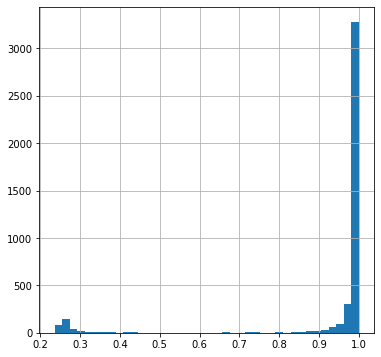

In [108]:
rel606_k12_link_1st["align_similar"].hist(figsize=(6,6), bins=40)

In [109]:
len(nc_gene_ids)

4190

In [110]:
rel606_k12_link_1st.align_similar.describe()

count    4190.000000
mean        0.929188
std         0.198632
min         0.236220
25%         0.984615
50%         1.000000
75%         1.000000
max         1.000000
Name: align_similar, dtype: float64

In [111]:
np.histogram(rel606_k12_link_1st.align_similar, bins=40)

(array([  87,  148,   40,   17,   12,    6,   10,   10,    3,    5,    6,
           2,    3,    0,    1,    2,    3,    2,    2,    2,    1,    1,
           5,    1,    0,    5,    4,    1,    3,    4,    3,    4,    7,
          17,   15,   25,   60,   96,  302, 3275]),
 array([0.23622047, 0.25531496, 0.27440945, 0.29350394, 0.31259843,
        0.33169291, 0.3507874 , 0.36988189, 0.38897638, 0.40807087,
        0.42716535, 0.44625984, 0.46535433, 0.48444882, 0.50354331,
        0.5226378 , 0.54173228, 0.56082677, 0.57992126, 0.59901575,
        0.61811024, 0.63720472, 0.65629921, 0.6753937 , 0.69448819,
        0.71358268, 0.73267717, 0.75177165, 0.77086614, 0.78996063,
        0.80905512, 0.82814961, 0.84724409, 0.86633858, 0.88543307,
        0.90452756, 0.92362205, 0.94271654, 0.96181102, 0.98090551,
        1.        ]))

In [112]:
rel606_k12_link_1st[rel606_k12_link_1st.align_similar<0.8].shape

(383, 7)

### 2.1.1 Merge dataframe by the amino acid matching 

In [113]:
pro_matching = pd.merge(
    left = rel606_k12_link_1st,
    right = ncbi_merge,
    how = "left",
    left_on = "rel606_gene_id",
    right_on = "locus_tag"
)
pro_matching.head(3)

,rel606_gene_id,rel606_pro_len,k12_gene_id,k12_pro_len,align_score,aligh_len,align_similar,locus_tag,name,location,old_locus_tag,product,note,start,end,sequence,protein_sequence
0,ECB_RS00005,21.0,EG11277,21.0,21.0,21.0,1.000000,ECB_RS00005,thrL,[189:255](+),ECB_00001,thr operon leader peptide,Derived by automated computational analysis us...,189,255,ATGAAACGCATTAGCACCACCATTACCACCACCATCACCATTACCA...,MKRISTTITTTITITTGNGAG
1,ECB_RS00010,820.0,EG10998,820.0,817.0,823.0,0.992710,ECB_RS00010,thrA,[335:2798](+),ECB_00002,bifunctional aspartate kinase/homoserine dehyd...,Derived by automated computational analysis us...,335,2798,ATGCGAGTGTTGAAGTTCGGCGGTACATCAGTGGCAAATGCAGAAC...,MRVLKFGGTSVANAERFLRVADILESNARQGQVATVLSAPAKITNH...
2,ECB_RS00015,310.0,EG10999,310.0,309.0,311.0,0.993569,ECB_RS00015,thrB,[2799:3732](+),ECB_00003,homoserine kinase,Derived by automated computational analysis us...,2799,3732,ATGGTTAAAGTTTATGCCCCGGCTTCCAGTGCCAATATGAGCGTCG...,MVKVYAPASSANMSVGFDVLGAAVTPVDGALLGDVVTVEAAETFSL...


In [114]:
pro_matching = pd.merge(
    left = pro_matching,
    right = ecyc_info,
    how = "left",
    left_on = "k12_gene_id",
    right_on = "UNIQUE-ID"
)
pro_matching.head(3)

,rel606_gene_id,rel606_pro_len,k12_gene_id,k12_pro_len,align_score,aligh_len,align_similar,locus_tag,name_x,location,old_locus_tag,product,note_x,start,end,sequence,protein_sequence,UNIQUE-ID,BLATTNER-ID,NAME,PRODUCT-NAME,SWISS-PROT-ID,REPLICON,START-BASE,END-BASE,SYNONYMS,SYNONYMS.1,SYNONYMS.2,SYNONYMS.3,GENE-CLASS,GENE-CLASS.1,GENE-CLASS.2,GENE-CLASS.3,gene_id_x,gene_sequence,pro_id,pro_sequence,gene_id_y,up_id,note_y,name_y
0,ECB_RS00005,21.0,EG11277,21.0,21.0,21.0,1.000000,ECB_RS00005,thrL,[189:255](+),ECB_00001,thr operon leader peptide,Derived by automated computational analysis us...,189,255,ATGAAACGCATTAGCACCACCATTACCACCACCATCACCATTACCA...,MKRISTTITTTITITTGNGAG,EG11277,b0001,thrL,<i>thr</i> operon leader peptide,P0AD86,COLI-K12,190.0,255.0,NaN,NaN,NaN,NaN,threonine,regulation,NaN,NaN,EG11277,ATGAAACGCATTAGCACCACCATTACCACCACCATCACCATTACCA...,EG11277-MONOMER,MKRISTTITTTITITTGNGAG,EG11277,P0AD86,<i>thr</i> operon leader peptide,ThrL
1,ECB_RS00010,820.0,EG10998,820.0,817.0,823.0,0.992710,ECB_RS00010,thrA,[335:2798](+),ECB_00002,bifunctional aspartate kinase/homoserine dehyd...,Derived by automated computational analysis us...,335,2798,ATGCGAGTGTTGAAGTTCGGCGGTACATCAGTGGCAAATGCAGAAC...,MRVLKFGGTSVANAERFLRVADILESNARQGQVATVLSAPAKITNH...,EG10998,b0002,thrA,fused aspartate kinase/homoserine dehydrogenase 1,P00561,COLI-K12,337.0,2799.0,thrA2,Hs,thrA1,thrD,homoserine,lysine,NaN,NaN,EG10998,ATGCGAGTGTTGAAGTTCGGCGGTACATCAGTGGCAAATGCAGAAC...,ASPKINIHOMOSERDEHYDROGI-MONOMER,MRVLKFGGTSVANAERFLRVADILESNARQGQVATVLSAPAKITNH...,EG10998,P00561,fused aspartate kinase/homoserine dehydrogenase 1,"ThrD, ThrA"
2,ECB_RS00015,310.0,EG10999,310.0,309.0,311.0,0.993569,ECB_RS00015,thrB,[2799:3732](+),ECB_00003,homoserine kinase,Derived by automated computational analysis us...,2799,3732,ATGGTTAAAGTTTATGCCCCGGCTTCCAGTGCCAATATGAGCGTCG...,MVKVYAPASSANMSVGFDVLGAAVTPVDGALLGDVVTVEAAETFSL...,EG10999,b0003,thrB,homoserine kinase,P00547,COLI-K12,2801.0,3733.0,NaN,NaN,NaN,NaN,threonine,NaN,NaN,NaN,EG10999,ATGGTTAAAGTTTATGCCCCGGCTTCCAGTGCCAATATGAGCGTCG...,HOMOSERKIN-MONOMER,MVKVYAPASSANMSVGFDVLGAAVTPVDGALLGDVVTVEAAETFSL...,EG10999,P00547,homoserine kinase,ThrB


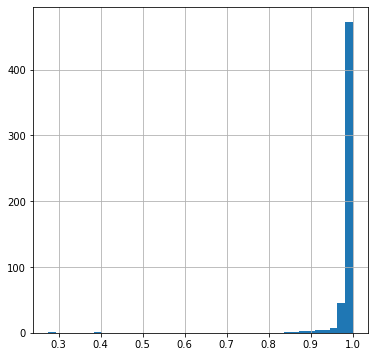

In [115]:
pro_matching[pro_matching.name_x.str.upper()==pro_matching.name_y.str.upper()].align_similar.hist(figsize=(6,6), bins=40)

From above figure, we see that majority of the matching genes have alignment score > than 0.8. Thus I would use 0.8 as threshold for reliable the matching. 

### 2.2 Matching by DNA sequence
There are 4190 NCBI records that have amino acid sequences. There are 4488 total NCBI records, thus there are 298 records have only nucleotide sequence.

Using amino acid sequence similarity score threshold 0.8, I'm going to use the rest of the records of the NCBI and Ecocyc for nucleotide sequence alignments.

In [80]:
ecyc_re_pair_ids = list(set(ecyc_info["UNIQUE-ID"].to_list()) - set(rel606_k12_link_1st[rel606_k12_link_1st.align_similar>=0.8].k12_gene_id.to_list()))
ncbi_re_pair_ids = list(set(ncbi_merge["locus_tag"].to_list()) - set(rel606_k12_link_1st[rel606_k12_link_1st.align_similar>=0.8].rel606_gene_id.to_list()))
len(ecyc_re_pair_ids), len(ncbi_re_pair_ids)

(752, 681)

In [81]:
# NCBI dataset that don't have protein sequences
ncbi_rest = ncbi_merge[ncbi_merge.locus_tag.isin(ncbi_re_pair_ids)].copy()
ncbi_rest.head(3)

,locus_tag,name,location,old_locus_tag,product,note,start,end,sequence,protein_sequence
18,ECB_RS00100,NaN,[19657:20617](-),ECB_00020,hypothetical protein,Derived by automated computational analysis us...,20617,19657,ATGAAGTGGCTTTTATTAATCACCTTGAGTCTATATTCTTTTATTG...,MKWLLLITLSLYSFIVQSAPCALTNVGEQRGTYILKPLSMKGNLTA...
19,ECB_RS00105,NaN,[20629:>21982](-),ECB_00021,fimbria/pilus outer membrane usher protein,internal stop; incomplete; partial in the midd...,21982,20629,AACAACCTGATCACATAATCGGGTACGATTTTATCCGATAACTATA...,None
20,ECB_RS00110,espX1,[22207:>23296](-),NaN,type III secretion system effector EspX1,incomplete; partial in the middle of a contig;...,23296,22207,ATCACCGAAGAGATTAAGATATATCAAGAATGCTATGAAAAATTCG...,None


In [82]:
ecyc_rest = ecyc_info[ecyc_info["UNIQUE-ID"].isin(ecyc_re_pair_ids)].copy()
ecyc_rest.head(3)

,UNIQUE-ID,BLATTNER-ID,NAME,PRODUCT-NAME,SWISS-PROT-ID,REPLICON,START-BASE,END-BASE,SYNONYMS,SYNONYMS.1,SYNONYMS.2,SYNONYMS.3,GENE-CLASS,GENE-CLASS.1,GENE-CLASS.2,GENE-CLASS.3,gene_id_x,gene_sequence,pro_id,pro_sequence,gene_id_y,up_id,note,name
5,G7904,b4623,insO,KpLE2 phage-like element; IS911B regulator fra...,P39212,COLI-K12,NaN,NaN,yi91,yi91b,b4283,ECK0257,transposon related,NaN,NaN,NaN,G7904,ATGAAAAAAAGAAATTTCAGCGCAGAGTTTAAACGCGAATCCGCTC...,NaN,NaN,NaN,NaN,NaN,NaN
8,EG12275,b3567,xylG,xylose ABC transporter ATP binding subunit,P37388,COLI-K12,3732201.0,3733742.0,NaN,NaN,NaN,NaN,carbon compounds,ABC superfamily ATP binding cytoplasmic component,NaN,NaN,EG12275,ATGCCTTATCTACTTGAAATGAAGAACATTACCAAAACCTTCGGCA...,XYLG-MONOMER,MPYLLEMKNITKTFGSVKAIDNVCLRLNAGEIVSLCGENGSGKSTL...,EG12275,P37388,xylose ABC transporter ATP binding subunit,NaN
9,G7150,b2192,insH-8,IS5 transposase and trans-activator,P0CE55,COLI-K12,2290081.0,2289065.0,trs5-8,yi52_8,NaN,NaN,transposon related,NaN,NaN,NaN,G7150,ATGTTTGTCATCTGGAGCCATAGAACAGGGTTCATCATGAGTCATC...,MONOMER0-4238,MFVIWSHRTGFIMSHQLTFADSEFSSKRRQTRKEIFLSRMEQILPW...,G7150,P0CE55,IS5 transposase and trans-activator,InsH-8


In [84]:
# matching by DNA sequences
(nc_rest_ids, nc_rest_len, 
 ec_rest_ids, ec_rest_len, 
 align_rest_scores, aligh_rest_len, align_rest_similar) = align_match(ncbi_rest, ecyc_rest,
                                                                      "locus_tag", "UNIQUE-ID",
                                                                      "sequence", "gene_sequence")

ECB_RS00100 G6772 0.49182879377431904 960.0 18.10478901863098 0
ECB_RS00105 EG11424 0.4888888888888889 1353.0 34.422788858413696 1
ECB_RS00110 G6772 0.5033063923585599 1089.0 24.758938789367676 2
ECB_RS00120 G0-10540 0.9942857142857143 698.0 7.58521294593811 3
ECB_RS00125 G7043 0.4978540772532189 347.0 1.4817030429840088 4
ECB_RS00220 EG11559 0.9877551020408163 1217.0 29.623302936553955 5
ECB_RS00420 G0-10696 0.4727272727272727 87.0 0.09429097175598145 6
ECB_RS00700 EG11678 0.6146435452793835 1275.0 31.455955982208252 7
ECB_RS00705 EG12325 0.7820895522388059 597.0 5.06003212928772 8
ECB_RS25300 G6796 0.4765625 198.0 0.41004180908203125 9
ECB_RS01035 EG30086 0.9897172236503856 1554.0 39.294349908828735 10
ECB_RS01040 EG30043 1.0 77.0 0.07789492607116699 11
ECB_RS01045 EG30008 1.0 76.0 0.07608222961425781 12
ECB_RS01050 EG30081 0.9826589595375722 2927.0 79.88226819038391 13
ECB_RS01055 EG30076 0.9666666666666667 116.0 0.13477492332458496 14
ECB_RS01060 EG30024 1.0 77.0 0.0734689235687255

ECB_RS04265 G6433 0.9873096446700508 2349.0 62.477330923080444 131
ECB_RS04335 EG11092 0.49390243902439024 333.0 1.2706069946289062 132
ECB_RS04340 EG11341 0.49019607843137253 1017.0 18.753653049468994 133
ECB_RS23350 G0-10738 0.48760330578512395 192.0 0.36264514923095703 134
ECB_RS04345 EG11979 0.4900924702774108 570.0 4.5101728439331055 135
ECB_RS04350 EG12112 0.5 222.0 0.4959690570831299 136
ECB_RS04355 G6311 0.5023183925811437 510.0 3.4858591556549072 137
ECB_RS23355 EG12203 0.4946236559139785 201.0 0.3821909427642822 138
ECB_RS04360 G7934 0.4965675057208238 342.0 1.3387298583984375 139
ECB_RS04365 EG11302 0.5150501672240803 234.0 0.5550057888031006 140
ECB_RS04370 G0-10432 0.5050167224080268 228.0 0.5246281623840332 141
ECB_RS04375 G7055 0.48695652173913045 858.0 13.96964406967163 142
ECB_RS04380 EG13139 0.48857142857142855 2415.0 63.39328908920288 143
ECB_RS04385 G0-9621 0.48854961832061067 189.0 0.3378310203552246 144
ECB_RS04390 EG10836 0.5047619047619047 234.0 0.55505013465881

ECB_RS08175 G6837 0.9231366459627329 1280.0 32.8160560131073 257
ECB_RS25455 G6736 0.48034934497816595 171.0 0.30636000633239746 258
ECB_RS08630 EG30111 1.0 77.0 0.08155989646911621 259
ECB_RS08635 EG30112 1.0 77.0 0.08123898506164551 260
ECB_RS22945 G0-8863 0.9722222222222222 108.0 0.13138508796691895 261
ECB_RS08755 G6916 0.9481907894736842 1154.0 28.326596975326538 262
ECB_RS08850 G6925 0.9874651810584958 713.0 9.056684732437134 263
ECB_RS08915 EG11208 0.48943148688046645 1900.0 53.91655993461609 264
ECB_RS09245 G6969 0.9958741619391439 1935.0 54.53039884567261 265
ECB_RS09320 EG12844 0.513595166163142 249.0 0.7255439758300781 266
ECB_RS09330 G7046 0.48375451263537905 183.0 0.3749539852142334 267
ECB_RS23735 G6832 0.5 270.0 0.825225830078125 268
ECB_RS09920 EG30054 1.0 87.0 0.08603191375732422 269
ECB_RS09925 G7991 1.0 74.0 0.07217288017272949 270
ECB_RS09930 EG30039 1.0 76.0 0.07076311111450195 271
ECB_RS09950 G0-10540 0.9942857142857143 698.0 7.479170083999634 272
ECB_RS09955 EG11

ECB_RS13445 EG30018 1.0 77.0 0.0741720199584961 386
ECB_RS13450 EG30018 1.0 77.0 0.07339692115783691 387
ECB_RS13455 EG30095 1.0 93.0 0.09644794464111328 388
ECB_RS25540 EG10836 0.4902597402597403 219.0 0.48434996604919434 389
ECB_RS13765 G6679 0.5157894736842106 153.0 0.22700905799865723 390
ECB_RS25545 G0-8876 0.5054945054945055 69.0 0.0563201904296875 391
ECB_RS13975 G6829 0.5104895104895105 216.0 0.4801468849182129 392
ECB_RS13980 G0-10540 1.0 698.0 7.907147169113159 393
ECB_RS13985 G7429 0.4927302100161551 441.0 2.746483087539673 394
ECB_RS13990 G7870 0.4907692307692308 999.0 18.710250854492188 395
ECB_RS13995 G6716 0.4910802775024777 1581.0 39.63276386260986 396
ECB_RS14000 EG11654 0.48739495798319327 951.0 16.679619073867798 397
ECB_RS14005 G6802 0.48758465011286684 984.0 17.9756178855896 398
ECB_RS14010 EG12275 0.5096774193548387 1500.0 36.31211304664612 399
ECB_RS14075 EG30060 1.0 77.0 0.07453608512878418 400
ECB_RS14080 EG30060 1.0 77.0 0.0749368667602539 401
ECB_RS14085 EG30

ECB_RS18320 G7471 0.49166666666666664 582.0 4.892226934432983 515
ECB_RS18325 G7382 0.4862905767412543 4851.0 82.59100794792175 516
ECB_RS18420 EG11424 0.5135460565924143 1254.0 29.72838020324707 517
ECB_RS18425 G6772 0.5046511627906977 984.0 18.1079580783844 518
ECB_RS18430 EG11353 0.5269058295964125 1026.0 19.266448974609375 519
ECB_RS18435 EG11425 0.5764439411098528 693.0 7.093379020690918 520
ECB_RS18440 G7471 0.5 504.0 3.5173299312591553 521
ECB_RS18445 G0-10540 1.0 698.0 7.447248935699463 522
ECB_RS18450 G7385 0.4954268292682927 498.0 3.335498094558716 523
ECB_RS18455 EG11352 0.5525914634146342 1017.0 19.078804969787598 524
ECB_RS18460 EG11340 0.6419753086419753 798.0 11.264003038406372 525
ECB_RS18470 EG11341 0.5923954372623574 1059.0 20.484528064727783 526
ECB_RS18535 EG11193 0.8272425249169435 825.0 13.239124059677124 527
ECB_RS25620 G7038 0.4903536977491961 867.0 13.93827199935913 528
ECB_RS18605 EG30092 1.0 95.0 0.10446810722351074 529
ECB_RS18610 G7218 0.5184705119896306 11

ECB_RS22075 EG10167 0.48587979724837077 1998.0 50.64828014373779 644
ECB_RS22080 G0-10531 0.5054945054945055 1157.0 26.181883096694946 645
ECB_RS22095 G6715 0.4990476190476191 785.0 11.065452098846436 646
ECB_RS25665 EG12844 0.5 258.0 0.7405807971954346 647
ECB_RS25270 G0-10540 0.8320209973753281 698.0 7.529167890548706 648
ECB_RS25670 G0-10694 0.4673913043478261 66.0 0.053610801696777344 649
ECB_RS24670 EG30111 0.4918032786885246 105.0 0.11744999885559082 650
ECB_RS24675 EG10992 0.5 189.0 0.36188793182373047 651
ECB_RS22160 G6681 0.49595687331536387 258.0 0.7449111938476562 652
ECB_RS22165 G0-10540 1.0 698.0 7.51072096824646 653
ECB_RS25275 G6835 0.5248618784530387 261.0 0.7586138248443604 654
ECB_RS25675 G7473 0.48562300319488816 246.0 0.6281318664550781 655
ECB_RS22230 G7918 0.9666339548577036 987.0 17.503288984298706 656
ECB_RS22260 EG10309 0.8009950248756219 483.0 3.314331293106079 657
ECB_RS22265 G0-10540 1.0 698.0 7.863473892211914 658
ECB_RS24700 G0-8901 0.5061728395061729 135.

In [91]:
rel606_k12_link_2nd = pd.DataFrame({
    "rel606_gene_id": nc_rest_ids,
    "rel606_pro_len": nc_rest_len,
    "k12_gene_id": ec_rest_ids,
    "k12_pro_len": ec_rest_len,
    "align_score": align_rest_scores,
    "aligh_len": aligh_rest_len,
    "align_similar": align_rest_similar
})

rel606_k12_link_2nd.to_csv("HelpFiles/rel606_k12_link_2nd.csv")
rel606_k12_link_2nd

,rel606_gene_id,rel606_pro_len,k12_gene_id,k12_pro_len,align_score,aligh_len,align_similar
0,ECB_RS00100,960.0,G6772,957.0,632.0,1285.0,0.491829
1,ECB_RS00105,1353.0,EG11424,1260.0,858.0,1755.0,0.488889
2,ECB_RS00110,1089.0,G6772,957.0,685.0,1361.0,0.503306
3,ECB_RS00120,698.0,G0-10540,698.0,696.0,700.0,0.994286
4,ECB_RS00125,347.0,G7043,351.0,232.0,466.0,0.497854
5,ECB_RS00220,1217.0,EG11559,1218.0,1210.0,1225.0,0.987755
6,ECB_RS00420,87.0,G0-10696,75.0,52.0,110.0,0.472727
7,ECB_RS00700,1275.0,EG11678,1239.0,957.0,1557.0,0.614644
8,ECB_RS00705,597.0,EG12325,597.0,524.0,670.0,0.782090
9,ECB_RS25300,198.0,G6796,180.0,122.0,256.0,0.476562


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12c8ee2d0>,
      dtype=object)

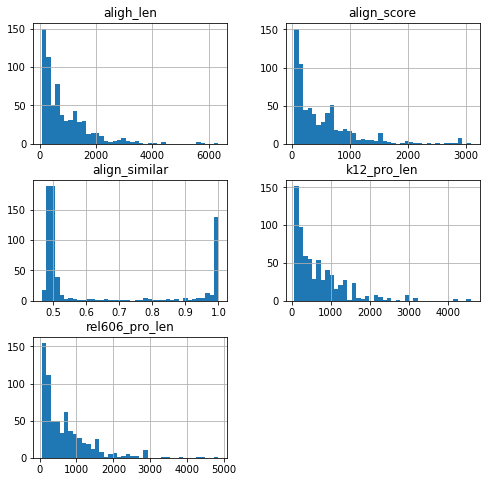

In [92]:
rel606_k12_link_2nd.hist(figsize=(8,8), bins=40)

In [97]:
rel606_k12_link_2nd.align_similar.describe()

count    681.000000
mean       0.641584
std        0.216417
min        0.467391
25%        0.492147
50%        0.502030
75%        0.930898
max        1.000000
Name: align_similar, dtype: float64

### 2.2.1 Merging the dataframe by nucleotide sequence alignments

In [93]:
nucleo_matching = pd.merge(
    left = rel606_k12_link_2nd,
    right = ncbi_merge,
    how = "left",
    left_on = "rel606_gene_id",
    right_on = "locus_tag"
)
nucleo_matching.head(3)

,rel606_gene_id,rel606_pro_len,k12_gene_id,k12_pro_len,align_score,aligh_len,align_similar,locus_tag,name,location,old_locus_tag,product,note,start,end,sequence,protein_sequence
0,ECB_RS00100,960.0,G6772,957.0,632.0,1285.0,0.491829,ECB_RS00100,NaN,[19657:20617](-),ECB_00020,hypothetical protein,Derived by automated computational analysis us...,20617,19657,ATGAAGTGGCTTTTATTAATCACCTTGAGTCTATATTCTTTTATTG...,MKWLLLITLSLYSFIVQSAPCALTNVGEQRGTYILKPLSMKGNLTA...
1,ECB_RS00105,1353.0,EG11424,1260.0,858.0,1755.0,0.488889,ECB_RS00105,NaN,[20629:>21982](-),ECB_00021,fimbria/pilus outer membrane usher protein,internal stop; incomplete; partial in the midd...,21982,20629,AACAACCTGATCACATAATCGGGTACGATTTTATCCGATAACTATA...,None
2,ECB_RS00110,1089.0,G6772,957.0,685.0,1361.0,0.503306,ECB_RS00110,espX1,[22207:>23296](-),NaN,type III secretion system effector EspX1,incomplete; partial in the middle of a contig;...,23296,22207,ATCACCGAAGAGATTAAGATATATCAAGAATGCTATGAAAAATTCG...,None


In [94]:
nucleo_matching = pd.merge(
    left = nucleo_matching,
    right = ecyc_info,
    how = "left",
    left_on = "k12_gene_id",
    right_on = "UNIQUE-ID"
)
nucleo_matching.head(3)

,rel606_gene_id,rel606_pro_len,k12_gene_id,k12_pro_len,align_score,aligh_len,align_similar,locus_tag,name_x,location,old_locus_tag,product,note_x,start,end,sequence,protein_sequence,UNIQUE-ID,BLATTNER-ID,NAME,PRODUCT-NAME,SWISS-PROT-ID,REPLICON,START-BASE,END-BASE,SYNONYMS,SYNONYMS.1,SYNONYMS.2,SYNONYMS.3,GENE-CLASS,GENE-CLASS.1,GENE-CLASS.2,GENE-CLASS.3,gene_id_x,gene_sequence,pro_id,pro_sequence,gene_id_y,up_id,note_y,name_y
0,ECB_RS00100,960.0,G6772,957.0,632.0,1285.0,0.491829,ECB_RS00100,NaN,[19657:20617](-),ECB_00020,hypothetical protein,Derived by automated computational analysis us...,20617,19657,ATGAAGTGGCTTTTATTAATCACCTTGAGTCTATATTCTTTTATTG...,MKWLLLITLSLYSFIVQSAPCALTNVGEQRGTYILKPLSMKGNLTA...,G6772,b1471,yddK,leucine-rich repeat domain-containing protein ...,P76123,COLI-K12,1545714.0,1544758.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G6772,ATGATCACTGACCTTATATTACACAATCATCCCAGGATGAAAACAA...,G6772-MONOMER,MITDLILHNHPRMKTITLNDNHIAHLNAKNTTKLEYLNLSNNNLLP...,G6772,P76123,leucine-rich repeat domain-containing protein ...,YddK
1,ECB_RS00105,1353.0,EG11424,1260.0,858.0,1755.0,0.488889,ECB_RS00105,NaN,[20629:>21982](-),ECB_00021,fimbria/pilus outer membrane usher protein,internal stop; incomplete; partial in the midd...,21982,20629,AACAACCTGATCACATAATCGGGTACGATTTTATCCGATAACTATA...,None,EG11424,b3622,waaL,O-antigen ligase,P27243,COLI-K12,3796948.0,3798207.0,rfaL,NaN,NaN,NaN,membrane,"surface antigens (ECA, O antigen of LPS)",NaN,NaN,EG11424,ATGCTAACATCCTTTAAACTTCATTCATTGAAACCTTACACTCTGA...,EG11424-MONOMER,MLTSFKLHSLKPYTLKSSMILEIITYILCFFSMIIAFVDNTFSIKI...,EG11424,P27243,O-antigen ligase,"WaaL, RfaL, M-antigen ligase, surface polymer:..."
2,ECB_RS00110,1089.0,G6772,957.0,685.0,1361.0,0.503306,ECB_RS00110,espX1,[22207:>23296](-),NaN,type III secretion system effector EspX1,incomplete; partial in the middle of a contig;...,23296,22207,ATCACCGAAGAGATTAAGATATATCAAGAATGCTATGAAAAATTCG...,None,G6772,b1471,yddK,leucine-rich repeat domain-containing protein ...,P76123,COLI-K12,1545714.0,1544758.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G6772,ATGATCACTGACCTTATATTACACAATCATCCCAGGATGAAAACAA...,G6772-MONOMER,MITDLILHNHPRMKTITLNDNHIAHLNAKNTTKLEYLNLSNNNLLP...,G6772,P76123,leucine-rich repeat domain-containing protein ...,YddK


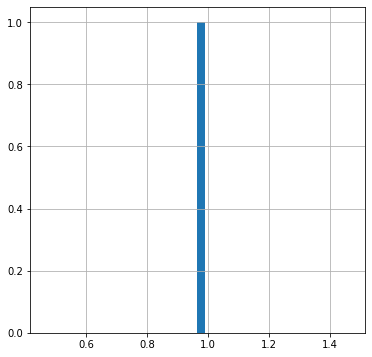

In [96]:
nucleo_matching[nucleo_matching.name_x.str.upper()==nucleo_matching.name_y.str.upper()].align_similar.hist(figsize=(6,6), bins=40)

I'd like to use a similar threshold for realiable match. But for now, I'd like to glue two dataframe together. 

# 3. Merge pro_matching and nucleo_matching

In [116]:
pro_matching[pro_matching.align_similar>=0.8].head(3)

,rel606_gene_id,rel606_pro_len,k12_gene_id,k12_pro_len,align_score,aligh_len,align_similar,locus_tag,name_x,location,old_locus_tag,product,note_x,start,end,sequence,protein_sequence,UNIQUE-ID,BLATTNER-ID,NAME,PRODUCT-NAME,SWISS-PROT-ID,REPLICON,START-BASE,END-BASE,SYNONYMS,SYNONYMS.1,SYNONYMS.2,SYNONYMS.3,GENE-CLASS,GENE-CLASS.1,GENE-CLASS.2,GENE-CLASS.3,gene_id_x,gene_sequence,pro_id,pro_sequence,gene_id_y,up_id,note_y,name_y
0,ECB_RS00005,21.0,EG11277,21.0,21.0,21.0,1.000000,ECB_RS00005,thrL,[189:255](+),ECB_00001,thr operon leader peptide,Derived by automated computational analysis us...,189,255,ATGAAACGCATTAGCACCACCATTACCACCACCATCACCATTACCA...,MKRISTTITTTITITTGNGAG,EG11277,b0001,thrL,<i>thr</i> operon leader peptide,P0AD86,COLI-K12,190.0,255.0,NaN,NaN,NaN,NaN,threonine,regulation,NaN,NaN,EG11277,ATGAAACGCATTAGCACCACCATTACCACCACCATCACCATTACCA...,EG11277-MONOMER,MKRISTTITTTITITTGNGAG,EG11277,P0AD86,<i>thr</i> operon leader peptide,ThrL
1,ECB_RS00010,820.0,EG10998,820.0,817.0,823.0,0.992710,ECB_RS00010,thrA,[335:2798](+),ECB_00002,bifunctional aspartate kinase/homoserine dehyd...,Derived by automated computational analysis us...,335,2798,ATGCGAGTGTTGAAGTTCGGCGGTACATCAGTGGCAAATGCAGAAC...,MRVLKFGGTSVANAERFLRVADILESNARQGQVATVLSAPAKITNH...,EG10998,b0002,thrA,fused aspartate kinase/homoserine dehydrogenase 1,P00561,COLI-K12,337.0,2799.0,thrA2,Hs,thrA1,thrD,homoserine,lysine,NaN,NaN,EG10998,ATGCGAGTGTTGAAGTTCGGCGGTACATCAGTGGCAAATGCAGAAC...,ASPKINIHOMOSERDEHYDROGI-MONOMER,MRVLKFGGTSVANAERFLRVADILESNARQGQVATVLSAPAKITNH...,EG10998,P00561,fused aspartate kinase/homoserine dehydrogenase 1,"ThrD, ThrA"
2,ECB_RS00015,310.0,EG10999,310.0,309.0,311.0,0.993569,ECB_RS00015,thrB,[2799:3732](+),ECB_00003,homoserine kinase,Derived by automated computational analysis us...,2799,3732,ATGGTTAAAGTTTATGCCCCGGCTTCCAGTGCCAATATGAGCGTCG...,MVKVYAPASSANMSVGFDVLGAAVTPVDGALLGDVVTVEAAETFSL...,EG10999,b0003,thrB,homoserine kinase,P00547,COLI-K12,2801.0,3733.0,NaN,NaN,NaN,NaN,threonine,NaN,NaN,NaN,EG10999,ATGGTTAAAGTTTATGCCCCGGCTTCCAGTGCCAATATGAGCGTCG...,HOMOSERKIN-MONOMER,MVKVYAPASSANMSVGFDVLGAAVTPVDGALLGDVVTVEAAETFSL...,EG10999,P00547,homoserine kinase,ThrB


In [117]:
nucleo_matching.head(3)

,rel606_gene_id,rel606_pro_len,k12_gene_id,k12_pro_len,align_score,aligh_len,align_similar,locus_tag,name_x,location,old_locus_tag,product,note_x,start,end,sequence,protein_sequence,UNIQUE-ID,BLATTNER-ID,NAME,PRODUCT-NAME,SWISS-PROT-ID,REPLICON,START-BASE,END-BASE,SYNONYMS,SYNONYMS.1,SYNONYMS.2,SYNONYMS.3,GENE-CLASS,GENE-CLASS.1,GENE-CLASS.2,GENE-CLASS.3,gene_id_x,gene_sequence,pro_id,pro_sequence,gene_id_y,up_id,note_y,name_y
0,ECB_RS00100,960.0,G6772,957.0,632.0,1285.0,0.491829,ECB_RS00100,NaN,[19657:20617](-),ECB_00020,hypothetical protein,Derived by automated computational analysis us...,20617,19657,ATGAAGTGGCTTTTATTAATCACCTTGAGTCTATATTCTTTTATTG...,MKWLLLITLSLYSFIVQSAPCALTNVGEQRGTYILKPLSMKGNLTA...,G6772,b1471,yddK,leucine-rich repeat domain-containing protein ...,P76123,COLI-K12,1545714.0,1544758.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G6772,ATGATCACTGACCTTATATTACACAATCATCCCAGGATGAAAACAA...,G6772-MONOMER,MITDLILHNHPRMKTITLNDNHIAHLNAKNTTKLEYLNLSNNNLLP...,G6772,P76123,leucine-rich repeat domain-containing protein ...,YddK
1,ECB_RS00105,1353.0,EG11424,1260.0,858.0,1755.0,0.488889,ECB_RS00105,NaN,[20629:>21982](-),ECB_00021,fimbria/pilus outer membrane usher protein,internal stop; incomplete; partial in the midd...,21982,20629,AACAACCTGATCACATAATCGGGTACGATTTTATCCGATAACTATA...,None,EG11424,b3622,waaL,O-antigen ligase,P27243,COLI-K12,3796948.0,3798207.0,rfaL,NaN,NaN,NaN,membrane,"surface antigens (ECA, O antigen of LPS)",NaN,NaN,EG11424,ATGCTAACATCCTTTAAACTTCATTCATTGAAACCTTACACTCTGA...,EG11424-MONOMER,MLTSFKLHSLKPYTLKSSMILEIITYILCFFSMIIAFVDNTFSIKI...,EG11424,P27243,O-antigen ligase,"WaaL, RfaL, M-antigen ligase, surface polymer:..."
2,ECB_RS00110,1089.0,G6772,957.0,685.0,1361.0,0.503306,ECB_RS00110,espX1,[22207:>23296](-),NaN,type III secretion system effector EspX1,incomplete; partial in the middle of a contig;...,23296,22207,ATCACCGAAGAGATTAAGATATATCAAGAATGCTATGAAAAATTCG...,None,G6772,b1471,yddK,leucine-rich repeat domain-containing protein ...,P76123,COLI-K12,1545714.0,1544758.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G6772,ATGATCACTGACCTTATATTACACAATCATCCCAGGATGAAAACAA...,G6772-MONOMER,MITDLILHNHPRMKTITLNDNHIAHLNAKNTTKLEYLNLSNNNLLP...,G6772,P76123,leucine-rich repeat domain-containing protein ...,YddK


In [118]:
frames = [pro_matching[pro_matching.align_similar>=0.8], nucleo_matching]

In [125]:
NCBI_K12_ann_final = pd.concat(frames)
NCBI_K12_ann_final.drop_duplicates(inplace=True)
NCBI_K12_ann_final.head(3)

,rel606_gene_id,rel606_pro_len,k12_gene_id,k12_pro_len,align_score,aligh_len,align_similar,locus_tag,name_x,location,old_locus_tag,product,note_x,start,end,sequence,protein_sequence,UNIQUE-ID,BLATTNER-ID,NAME,PRODUCT-NAME,SWISS-PROT-ID,REPLICON,START-BASE,END-BASE,SYNONYMS,SYNONYMS.1,SYNONYMS.2,SYNONYMS.3,GENE-CLASS,GENE-CLASS.1,GENE-CLASS.2,GENE-CLASS.3,gene_id_x,gene_sequence,pro_id,pro_sequence,gene_id_y,up_id,note_y,name_y
0,ECB_RS00005,21.0,EG11277,21.0,21.0,21.0,1.000000,ECB_RS00005,thrL,[189:255](+),ECB_00001,thr operon leader peptide,Derived by automated computational analysis us...,189,255,ATGAAACGCATTAGCACCACCATTACCACCACCATCACCATTACCA...,MKRISTTITTTITITTGNGAG,EG11277,b0001,thrL,<i>thr</i> operon leader peptide,P0AD86,COLI-K12,190.0,255.0,NaN,NaN,NaN,NaN,threonine,regulation,NaN,NaN,EG11277,ATGAAACGCATTAGCACCACCATTACCACCACCATCACCATTACCA...,EG11277-MONOMER,MKRISTTITTTITITTGNGAG,EG11277,P0AD86,<i>thr</i> operon leader peptide,ThrL
1,ECB_RS00010,820.0,EG10998,820.0,817.0,823.0,0.992710,ECB_RS00010,thrA,[335:2798](+),ECB_00002,bifunctional aspartate kinase/homoserine dehyd...,Derived by automated computational analysis us...,335,2798,ATGCGAGTGTTGAAGTTCGGCGGTACATCAGTGGCAAATGCAGAAC...,MRVLKFGGTSVANAERFLRVADILESNARQGQVATVLSAPAKITNH...,EG10998,b0002,thrA,fused aspartate kinase/homoserine dehydrogenase 1,P00561,COLI-K12,337.0,2799.0,thrA2,Hs,thrA1,thrD,homoserine,lysine,NaN,NaN,EG10998,ATGCGAGTGTTGAAGTTCGGCGGTACATCAGTGGCAAATGCAGAAC...,ASPKINIHOMOSERDEHYDROGI-MONOMER,MRVLKFGGTSVANAERFLRVADILESNARQGQVATVLSAPAKITNH...,EG10998,P00561,fused aspartate kinase/homoserine dehydrogenase 1,"ThrD, ThrA"
2,ECB_RS00015,310.0,EG10999,310.0,309.0,311.0,0.993569,ECB_RS00015,thrB,[2799:3732](+),ECB_00003,homoserine kinase,Derived by automated computational analysis us...,2799,3732,ATGGTTAAAGTTTATGCCCCGGCTTCCAGTGCCAATATGAGCGTCG...,MVKVYAPASSANMSVGFDVLGAAVTPVDGALLGDVVTVEAAETFSL...,EG10999,b0003,thrB,homoserine kinase,P00547,COLI-K12,2801.0,3733.0,NaN,NaN,NaN,NaN,threonine,NaN,NaN,NaN,EG10999,ATGGTTAAAGTTTATGCCCCGGCTTCCAGTGCCAATATGAGCGTCG...,HOMOSERKIN-MONOMER,MVKVYAPASSANMSVGFDVLGAAVTPVDGALLGDVVTVEAAETFSL...,EG10999,P00547,homoserine kinase,ThrB


In [126]:
NCBI_K12_ann_final.shape

(4493, 41)

In [124]:
NCBI_K12_ann_final[NCBI_K12_ann_final.duplicated(subset="rel606_gene_id", keep=False)]

,rel606_gene_id,rel606_pro_len,k12_gene_id,k12_pro_len,align_score,aligh_len,align_similar,locus_tag,name_x,location,old_locus_tag,product,note_x,start,end,sequence,protein_sequence,UNIQUE-ID,BLATTNER-ID,NAME,PRODUCT-NAME,SWISS-PROT-ID,REPLICON,START-BASE,END-BASE,SYNONYMS,SYNONYMS.1,SYNONYMS.2,SYNONYMS.3,GENE-CLASS,GENE-CLASS.1,GENE-CLASS.2,GENE-CLASS.3,gene_id_x,gene_sequence,pro_id,pro_sequence,gene_id_y,up_id,note_y,name_y
141,ECB_RS00775,841.0,EG10605,844.0,838.0,847.0,0.989374,ECB_RS00775,mrcB,[167580:170106](+),ECB_00148,bifunctional glycosyl transferase/transpeptidase,Derived by automated computational analysis us...,167580,170106,ATGGCCGGGAATGACCGCGAGCCAATTGGACGCAAAGGGAAACCGA...,MAGNDREPIGRKGKPTRPVKQKVSRRRYEDDDDYDDYDDYEDEEPM...,EG10605,b0149,mrcB,PBP1B&gamma;,NaN,COLI-K12,164730.0,167264.0,pbpF,ponB,NaN,NaN,murein (peptidoglycan),amino sugar conversions,cell division,drug resistance/sensitivity,EG10605,ATGGCCGGGAATGACCGCGAGCCAATTGGACGCAAAGGGAAACCGA...,EG10605-MONOMER,MAGNDREPIGRKGKPTRPVKQKVSRRRYEDDDDYDDYDDYEDEEPM...,EG10605,P02919,peptidoglycan glycosyltransferase / peptidogly...,"PonB, PbpF, PBP1B, PBP1Bs, MrcB, PBP1B&alpha;,..."
142,ECB_RS00775,841.0,EG10605,844.0,838.0,847.0,0.989374,ECB_RS00775,mrcB,[167580:170106](+),ECB_00148,bifunctional glycosyl transferase/transpeptidase,Derived by automated computational analysis us...,167580,170106,ATGGCCGGGAATGACCGCGAGCCAATTGGACGCAAAGGGAAACCGA...,MAGNDREPIGRKGKPTRPVKQKVSRRRYEDDDDYDDYDDYEDEEPM...,EG10605,b0149,mrcB,PBP1B&gamma;,NaN,COLI-K12,164730.0,167264.0,pbpF,ponB,NaN,NaN,murein (peptidoglycan),amino sugar conversions,cell division,drug resistance/sensitivity,EG10605,ATGGCCGGGAATGACCGCGAGCCAATTGGACGCAAAGGGAAACCGA...,MONOMER0-4521,MPRKGKGKGKGRKPRGKRGWLWLLLKLAIVFAVLIAIYGVYLDQKI...,EG10605,NaN,PBP1B&gamma;,"PonB, PbpF, MrcB, penicillin binding protein 1..."
410,ECB_RS02205,643.0,EG10245,643.0,643.0,643.0,1.000000,ECB_RS02205,NaN,[464158:466090](+),ECB_00421,DNA polymerase III subunit gamma/tau,Derived by automated computational analysis us...,464158,466090,ATGAGTTATCAGGTCTTAGCCCGAAAATGGCGCCCACAAACCTTTG...,MSYQVLARKWRPQTFADVVGQEHVLTALANGLSLGRIHHAYLFSGT...,EG10245,b0470,dnaX,DNA polymerase III subunit &gamma;,P06710-2,COLI-K12,492092.0,494023.0,dnaZ,NaN,NaN,NaN,DNA replication,NaN,NaN,NaN,EG10245,ATGAGTTATCAGGTCTTAGCCCGAAAATGGCGCCCACAAACCTTTG...,EG10245-MONOMER,MSYQVLARKWRPQTFADVVGQEHVLTALANGLSLGRIHHAYLFSGT...,EG10245,P06710-1,DNA polymerase III subunit &tau;,"DnaZ, DnaX, DNA elongation factor III"
411,ECB_RS02205,643.0,EG10245,643.0,643.0,643.0,1.000000,ECB_RS02205,NaN,[464158:466090](+),ECB_00421,DNA polymerase III subunit gamma/tau,Derived by automated computational analysis us...,464158,466090,ATGAGTTATCAGGTCTTAGCCCGAAAATGGCGCCCACAAACCTTTG...,MSYQVLARKWRPQTFADVVGQEHVLTALANGLSLGRIHHAYLFSGT...,EG10245,b0470,dnaX,DNA polymerase III subunit &gamma;,P06710-2,COLI-K12,492092.0,494023.0,dnaZ,NaN,NaN,NaN,DNA replication,NaN,NaN,NaN,EG10245,ATGAGTTATCAGGTCTTAGCCCGAAAATGGCGCCCACAAACCTTTG...,MONOMER0-2383,MSYQVLARKWRPQTFADVVGQEHVLTALANGLSLGRIHHAYLFSGT...,EG10245,P06710-2,DNA polymerase III subunit &gamma;,"DnaZ, DnaX"
425,ECB_RS02275,834.0,G6260,834.0,834.0,834.0,1.000000,ECB_RS02275,copA,[481042:483547](-),ECB_00435,copper-exporting P-type ATPase CopA,Derived by automated computational analysis us...,483547,481042,ATGTCACAAACTATCGACCTGACCCTGGACGGCCTGTCCTGCGGTC...,MSQTIDLTLDGLSCGHCVKRVKESLEQRPDVEQADVSITEAHVTGT...,G6260,b0484,copA,soluble Cu<sup>+</sup> chaperone,Q59385-2,COLI-K12,511379.0,508875.0,ybaR,NaN,NaN,NaN,transport,NaN,NaN,NaN,G6260,ATGTCACAAACTATCGACCTGACCCTGGACGGCCTGTCCTGCGGTC...,G6260-MONOMER,MSQTIDLTLDGLSCGHCVKRVKESLEQRPDVEQADVSITEAHVTGT...,G6260,Q59385-1,Cu<sup>+</sup> exporting P-type ATPase,"YbaR, CopA, AtcU"
426,ECB_RS02275,834.0,G6260,834.0,834.0,834.0,1.000000,ECB_RS02275,copA,[481042:483547](-),ECB_00435,copper-exporting P-type ATPase CopA,Derived by automated computational analysis us...,483547,481042,ATGTCACAAACTATCGACCTGACCCTGGACGGCCTGTCCTGCGGTC...,MSQTIDLTLD

By observing, the duplication is due to repetitive annotation of gene product name in ecocyc K12 database. Thus it is safe to drop one of it. 

After droping the duplicates, the dataframe shape should be 4488. 

In [127]:
NCBI_K12_ann_final.drop_duplicates(subset = "rel606_gene_id", inplace = True)
NCBI_K12_ann_final.shape

(4488, 41)

In [128]:
NCBI_K12_ann_final.to_csv("ncbi_rel606_ecyc_k12_ann_matching_raw.csv") # This database containing values that have lower similarity score

# Save the gene id matching to a .csv file if the similarity score is larger than threshold 0.8
NCBI_K12_ann_final[NCBI_K12_ann_final.align_similar>=0.8].to_csv("ncbi_rel606_ecyc_k12_ann_matching_final.csv")

In [129]:
NCBI_K12_ann_final.shape, NCBI_K12_ann_final[NCBI_K12_ann_final.align_similar>=0.8].shape

((4488, 41), (3998, 41))

In conclusion, out of 4488 genes annotated by NCBI, 3998 of them is able to match with K-12 strain with higher than 80% sequence similarities.